# Group 5 SA4110 - Course Assignment

Team Members:<br>
Ye Naung Khant<br>
Shin Kaung Pyae Shan<br>
Fong Ying Jie<br>
Yeo Chee Siang<br>
Chan Wei Quan<br>
Deng Qian

## Introduction
This notebook outlines the training process for training a CNN Image classifier that is used to classify 4 categories of fruits which are:
1) apple
2) orange
3) banana
4) mixed

The CNN model used for training and testing will be from the 2 image folders provided which are:
1) train
2) test

For a comprehensive description of all the files submitted, please refer to the README.txt.<br>

The report will be structured in the sequence:<br>
Part 1 - Loading of the original data<br>
Part 2 - Further data processing and balancing the number of samples in the dataset, and correcting of any mislabeling <br>
Part 3 - Performing Data Augmentation<br>
Part 4 - Tuning the model architecture, hyperparameter tuning and Conclusion<br>

# Part 1 - Loading of the original data

In this section, the following are performed:
- Extracting the file names of the images provided in the train and test folders and saving them to a csv file.
- Perform one-hot encoding on the extracted file names to represent the 4 classes of fruits provided
- Preparing the data using the csv file and training a base model to show the performance of a CNN model without any data cleaning, data augmentation, and hyperparameter tuning

In [1]:
# import the relevant libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import random
import datetime
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob

# set the seed value
seed = 42

# set pythonhashseed to a fixed value
os.environ['PYTHONHASHSEED']=str(seed)

# set the python pseudorandom number generator to a fixed value
random.seed(seed)

# set the numpy and tf pseudorandom number generator to a fixed value
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

# configure new session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
# Define the functions that will be used

def load_img_names(fpath):
    """
    Creates a dataframe that contains the file name of all the images in the specified file path.
    Parameters:
    fpath (str): The directory where the images are located in.
    Returns:
    df (pandas DataFrame): Dataframe with the file names of all the images in the provided folder
    """
    df = pd.DataFrame()
    with os.scandir(fpath) as imgs:
        fname = []
        for img in imgs:
            # note that the train and test folders only contain images and no other type of files
            if not img.name.startswith('.') and img.is_file():
                fname.append(img.name)
        df["fname"] = pd.Series(fname)
    return df


def encode_onehot(fruitList, df):
    """
    This function takes in the dataframe containing the file names of the fruits in the folder and performs 
    one hot encoding on the dataframe using the list of fruit classes provided. 
    Parameters:
    fruitList (list): A list of strings containing the classes to sort the fruits into
    df (pandas DataFrame): Dataframe with the file names of all the images
    Returns:
    df (pandas DataFrame): Dataframe with the file names of all the images with onehot encoding performed
    """
    # Convert the fruit list and filename in df to lowercase to reduce errors
    fruitList = [fruit.lower() for fruit in fruitList]
    df["fname"] = df["fname"].str.lower()
    
    # Create a dataframe of categories and concatenate it with the original df
    classifier_df = pd.DataFrame(0,index=df.index, columns=fruitList)
    df = pd.concat([df, classifier_df],axis=1)
    
    # Iterate through the list of fruits and assign the fruit with a number
    for fruit in fruitList:
        # if list contains partial string, assign it with the value 1
        bool_mat = df["fname"].str.contains(fruit)
        df.loc[bool_mat, fruit] = 1
        
    return df


def read_img(img_fname, folderName, reshaped_size):
    """
    Read the images from the specified folder name from the file names provided in a pd series and return a
    numpy array of images.
    Parameters:
    img_fname (pd.Series): Pd series containing the list of file names
    folderName (str): The name of the folder containing the images
    reshaped_size (list): The dimensions to reshape the numpy array to
    Returns:
    A numpy array of images
    """
    for fname in img_fname:
        # this is to skip any hidden files in the folder
        if fname[0] == '.':
            continue
        # get the filepath of the images
        fpath = os.path.join(os.getcwd(), folderName, fname)
        with Image.open(fpath) as img:
            # convert all the images to RGB format and resize
            img_conv = img.convert("RGB")        
            img = img_conv.resize((reshaped_size), Image.LANCZOS)
            # if x_train exists, append to the np array
            try:
                x_train = np.concatenate((x_train, np.array(img)))
            # if x_train does not exist, create a x_train
            except:
                x_train = img   
            
    # get number of dimensions of array
    num_of_dims = x_train.shape[2]
    x_train =  np.reshape(x_train, (-1,reshaped_size[0],reshaped_size[1],num_of_dims))     
    
    return x_train


def prep_data(csv_fname, folder_name, reshaped_size):    
    """
    Reads the csv file containing the file names and the labels for each class. Splits the df into x_data and y_data
    Parameters:
    csv_fname (str): File name of the csv files that has the image files name and the labels in onehot encoding form
    folder_name (str): The name of the folder that contains the images
    Returns:
    x_data and y_data which are the input and output data for the cnn
    """
    data = pd.read_csv(csv_fname)
    
    # get the input data (numpy array of images) for the cnn
    x_data = read_img(pd.Series(data["fname"]),folder_name, reshaped_size) 

    # get y data in onehot encoding format, make sure the labels are all same type
    y_data = data.iloc[:,[1,2,3,4]].astype(float).to_numpy()
    
    return x_data, y_data


def get_input_output(data_x, data_y):
    """
    Returns the input shape and the shape for the output layer for the cnn model
    Parameters:
    data_x (np.array): The input data for the cnn
    data_y (np.array): The output labels
    Returns:
    Dimensions of the input for the cnn and the number of neurons for output layer
    """
    x_input_shape = data_x.shape[1:]
    output_layer = data_y.shape[1]
    return x_input_shape,output_layer


def prep_training_data(train_csv_fname, train_folder_name, validation_split, img_rescale, reshaped_size):
    """
    This function should only be used for training data.
    This functions will process and prepare the data for usage in the model
    Parameters:
    train_csv_fname (str): The file name of the csv files that has the image files name and the labels
    train_folder_name (str): The name of the folder that contains the images
    validation_split (float): The ratio to split the train data to train and validation
    img_rescale (float): The dimensions to rescale the data to
    reshaped_size (list): A list of values to reshape the images to
    Returns:
    np.arrays of input features and output labels for: 
    1) training data, validation data 
    The dimensions for the input and output layer for the CNN
    """
    x_data, y_data = prep_data(train_csv_fname, train_folder_name, reshaped_size)
    x_input_shape, output_layer = get_input_output(x_data, y_data)
    
    # apply feature scaling on the x_data data
    x_data = x_data*img_rescale
    
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=seed, shuffle=True,
                                                        test_size=validation_split)

    return x_train, x_val, y_train, y_val, x_input_shape, output_layer


def prep_test_data(test_csv_fname, test_folder_name, img_rescale, reshaped_size):
    """
    This function should only be used for test data. 
    This will process the data and prepare for testing in the model
    Parameters:
    test_csv_fname (str): The file name of the csv files that has the image files name and the labels
    test_folder_name (str): The name of the folder that contains the images
    img_rescale (float): The dimensions to rescale the data to
    reshaped_size (list): A list of values to reshape the images to
    Returns:
    np.arrays of input features and output labels for the test data
    """
    x_test, y_test = prep_data(test_csv_fname, test_folder_name, reshaped_size)   
    # apply feature scaling on the x_test data
    x_test = x_test*img_rescale
    
    return x_test, y_test 


# Create a base model to test the data
def created_untuned_model(x_input_shape, output_layer):
    """
    Creates a cnn model for initial testing and it will be tuned in later parts
    Parameters:
    x_input_shape (tuple): the shape of the input data
    output_layer (int): the number of neurons in the output layer
    Returns:
    keras model object.
    """
    # set a seed for weight initialisation
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    # create the model
    model = tf.keras.Sequential()
    # add in convolutional layer and max pooling layer
    model.add(tf.keras.layers.Conv2D(filters=16, 
         kernel_size=(2, 2), activation="relu", input_shape=(x_input_shape), kernel_initializer=initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    # flatten 
    model.add(tf.keras.layers.Flatten())
    # add dense layers
    model.add(tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer=initializer))    
    # add the output layer
    model.add(tf.keras.layers.Dense(units=output_layer, activation="softmax", kernel_initializer=initializer))    
    # specify the optimiser and compile the model
    model.compile(loss="categorical_crossentropy", optimizer="adam", 
                    metrics=["accuracy"])
    return model


def train_model(model, x_train, y_train, batch_size, epochs, callbacks, x_val, y_val):
    """
    Trains the keras model using the given data
    Parameters:
    model (tf.keras.Model): The model to be trained
    x_train (np.array): The input training data for the cnn
    y_train (np.array): The output training data for the cnn
    epochs: The number of times the entire dataset provided is used to train the model
    callbacks (tf.keras.callbacks.Callback): the list of callbacks to use during training
    x_val (np.array): the input validation data for the cnn
    y_val (np.array): the output validation data for the cnn
    Returns:
    history object containing training/validation loss and accuracy
    """
    history = model.fit(x = x_train, y = y_train
                , batch_size = batch_size, epochs = epochs
                , callbacks = callbacks, validation_data = (x_val,y_val))    
    return history


def test_model(model, x_test, y_test):
    """
    Evaluates the model on the given test data
    Parameters:
    model (tf.keras.Model): The model to be evaluated
    x_test (np.array): The input data for testing
    y_test (np.array): The output data for testing
    Returns:
    A list of test loss and test accuracy
    """
    return model.evaluate(x=x_test, y=y_test)


def save_model(model, path):
    """
    Saves the given model to a specified file path
    Parameters:
    model (tf.keras.Model): The model to be saved
    path (str): The file path to save the model to
    Returns:
    None
    """
    model.save(path)
    print("Model saved!")
    
    
def show_logger_plot(fpath, title):
    """
    This functions shows the training and validation loss and accuracy using the provided filepath of the 
    logger file from model training
    Parameters:
    fpath (str): The directory and the file name of the logger
    title (str): The title to display in the plot
    Returns:
    None
    """
    # Read the provided log file
    log_data = pd.read_csv(fpath, sep=',', skiprows=1, names=["epoch", "accuracy", "loss"
                                                              ,"val_accuracy","val_loss"])

    # Extract the relevant columns for plotting
    epoch = log_data["epoch"]
    accuracy = log_data["accuracy"]
    loss = log_data["loss"]
    val_accuracy = log_data["val_accuracy"]
    val_loss = log_data["val_loss"]

    # Create subplots with two columns
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot the loss
    axes[0].plot(epoch, loss, label="Training Loss")
    axes[0].plot(epoch, val_loss, label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss")
    axes[0].legend()

    # Plot the accuracy
    axes[1].plot(epoch, accuracy, label="Training Accuracy")
    axes[1].plot(epoch, val_accuracy, label="Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training & Validation Accuracy")
    axes[1].legend()
    
    # Add the overall title
    fig.suptitle(title, fontsize=23, fontweight='bold')
    
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()

### Extract the file names and perform one hot encoding on the extracted file names

In [3]:
# List of classifiers to use for hot encoding
fruitList = ["apple", "banana", "orange", "mixed"]

# Get the file paths for the folders containing the train images and test
img_fpath_train = os.path.join(os.getcwd(), "train")
img_fpath_test = os.path.join(os.getcwd(), "test")

# Folder to save the csv file containing the information to
folder="image-info-csv/"

# Get pd df containing the fnames and encode it
train_fname = load_img_names(img_fpath_train)
train_df = encode_onehot(fruitList, train_fname)

# Save the csv file
train_df.to_csv(os.path.join(folder, "train_original.csv"),index=False)

# Get pandas df containing the fnames and classifiers
test_fname = load_img_names(img_fpath_test)
test_df = encode_onehot(fruitList, test_fname)

# save the csv file
test_df.to_csv(os.path.join(folder, "test.csv"),index=False)

### Load the extracted images and train the model and evaluate

In [4]:
# Define the parameters that will be used for Parts 1, 2, and 3.
img_rescale = 1./255
validation_split = 0.15
reshaped_size=[100,100]
# note that 100 epochs is used in training as earlystopping callback is applied
epochs = 100
batch_size = 64

# Define the callbacks
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', restore_best_weights=True, patience=10)
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [5]:
# Prepare the data for training and testing
csv_folder = "image-info-csv"

# Get the file paths
train_csv_fname = os.path.join(csv_folder, "train_original.csv")
train_folder_name = "train"
test_csv_fname = os.path.join(csv_folder, "test.csv")
test_folder_name = "test"

# Generate the data for training and testing
x_train, x_val, y_train, y_val, x_input_shape, output_layer = prep_training_data(train_csv_fname, train_folder_name
                                                                 , validation_split, img_rescale, reshaped_size)

x_test, y_test = prep_test_data(test_csv_fname, test_folder_name, img_rescale, reshaped_size)

# Show the number of samples in the dataset
print(f"The number of samples in x_train is {len(x_train)}, y_train is {len(y_train)}")
print(f"The number of samples in x_validation is {len(x_val)}, y_validation is {len(y_val)}")
print(f"The number of samples in x_test is {len(x_test)}, y_test is {len(y_test)}")

/Users/chanweiquan/miniforge3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The number of samples in x_train is 204, y_train is 204
The number of samples in x_validation is 36, y_validation is 36
The number of samples in x_test is 60, y_test is 60


In [6]:
# Create a csv logger callback to save results of training
logger_original_name = f"logger/train_model/01_original_model-{current_time}.log"
logger_original = tf.keras.callbacks.CSVLogger(logger_original_name, separator=",", append=False)
callbacks_original = [earlyStopping, logger_original]

# create the model
original_model = created_untuned_model(x_input_shape, output_layer)

# train the model
original_model_history = train_model(original_model, x_train = x_train, y_train = y_train
                , batch_size = batch_size, epochs = epochs
                , callbacks = callbacks_original, x_val=x_val, y_val=y_val)

Epoch 1/100


2023-05-25 10:52:37.368009: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 1s 104ms/step - loss: 3.8115 - accuracy: 0.3480 - val_loss: 1.8682 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 0s 82ms/step - loss: 2.0798 - accuracy: 0.3480 - val_loss: 2.0665 - val_accuracy: 0.3333
Epoch 3/100
4/4 [==============================] - 0s 83ms/step - loss: 1.4837 - accuracy: 0.4657 - val_loss: 1.1430 - val_accuracy: 0.5833
Epoch 4/100
4/4 [==============================] - 0s 83ms/step - loss: 1.2978 - accuracy: 0.5637 - val_loss: 1.1357 - val_accuracy: 0.6111
Epoch 5/100
4/4 [==============================] - 0s 83ms/step - loss: 1.0966 - accuracy: 0.7255 - val_loss: 0.8263 - val_accuracy: 0.6944
Epoch 6/100
4/4 [==============================] - 0s 83ms/step - loss: 0.7376 - accuracy: 0.7402 - val_loss: 0.7426 - val_accuracy: 0.8611
Epoch 7/100
4/4 [==============================] - 0s 83ms/step - loss: 0.5541 - accuracy: 0.8284 - val_loss: 0.6653 - val_accuracy: 0.7222
Epoch 8/100
4/4 [==============

The accuracy of the untuned original model on the test dataset is: 
2/2 [==============================] - 0s 22ms/step - loss: 0.5772 - accuracy: 0.8000
[0.5772355198860168, 0.800000011920929] 



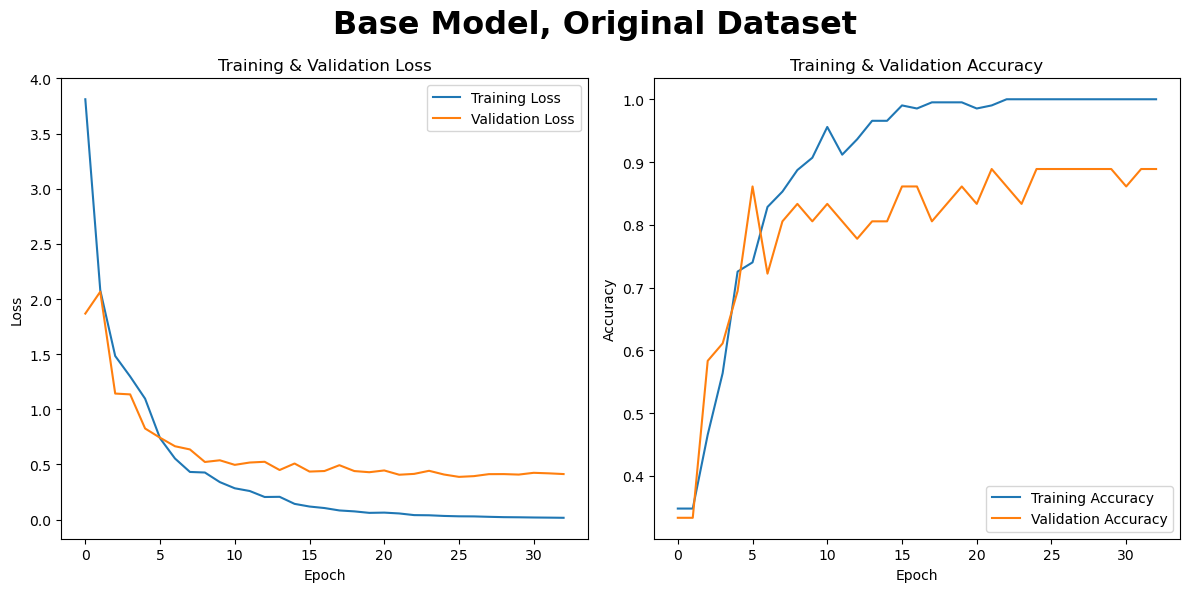

In [7]:
# Test the model
print("The accuracy of the untuned original model on the test dataset is: ")
original_model_results = test_model(original_model, x_test, y_test)
print(original_model_results, "\n")
    
# Show the plot of the training and validation loss and accuracy
show_logger_plot(logger_original_name, "Base Model, Original Dataset")

Based on the results above, it can be seen that the CNN model is able to make good predictions which can be seen from the training, validation and test accuracy. However, it can be seen from the graph above that the training accuracy curves shows signs of overfitting whereas the validation accuracy can be further improved. This will be addressed in the next part by balancing the data samples and correcting any mislabeling in the image labels to improve the overall accuracy of the model

# Part 2 - Further data processing and balancing the number of samples in the dataset, and correcting of any mislabeling 

Building on from the previous section, Part 2 focuses on this:
- Correcting any mislabelling in the 4 fruit classes
- Balancing the samples in the training data to ensure an equal balance amongst all the fruit classes

In report, the primary metric to be used to evaluate the performance of the model will be the accuracy.

### Correct data labels

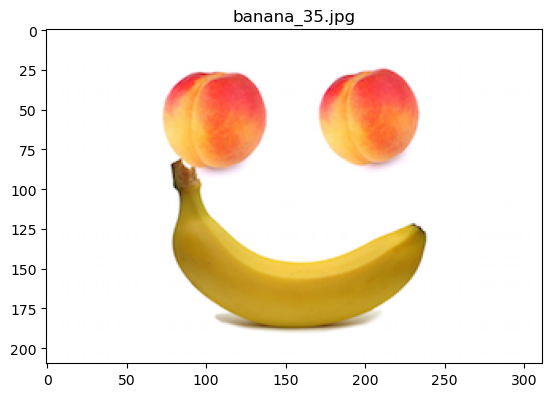

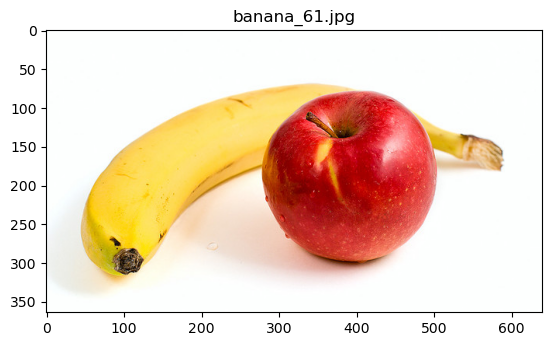

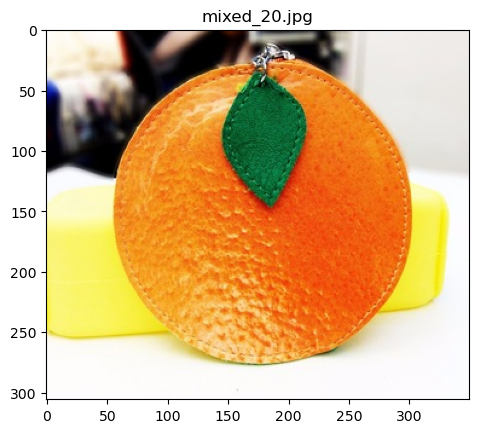

In [8]:
# Create pandas dataframe of the labels to be updated
update_data = [
    ("banana_35.jpg", {"apple": 0, "banana": 0, "orange": 0, "mixed": 1}),
    ("banana_61.jpg", {"apple": 0, "banana": 0, "orange": 0, "mixed": 1}),
    ("mixed_20.jpg", {"apple": 0, "banana": 0, "orange": 1, "mixed": 0})
]

# Reshape the data
formatted_data = [(fname, values["apple"], values["banana"], values["orange"], values["mixed"]) 
                  for fname, values in update_data]

# Create the DataFrame with the correct column names
update_df = pd.DataFrame(formatted_data, columns=["fname", "apple", "banana", "orange", "mixed"])
update_df[["apple", "banana", "orange", "mixed"]] = update_df[["apple", "banana", "orange", "mixed"]].astype(float)


# Display the images that are updated
for index, row in update_df.iterrows():
    img = mpimg.imread(os.path.join(img_fpath_train, row[0]))

    # Plot the image
    plt.imshow(img)
    plt.title(row[0])
    plt.show()

# Read the original and update CSV files
original_df = pd.read_csv(os.path.join(folder, "train_original.csv"))

# Iterate over each filename in the update dataframe
for fname in update_df["fname"]:
    if fname in original_df["fname"].tolist():
        base_index = original_df.loc[original_df['fname'] == fname].index.tolist()
        update_index = update_df.loc[update_df['fname'] == fname].index.tolist()
        original_df.iloc[base_index, 1:] = update_df.iloc[update_index, 1:]

# Save the updated dataframe to a new CSV file
original_df.to_csv(os.path.join(folder, "train_updated.csv"), index=False)

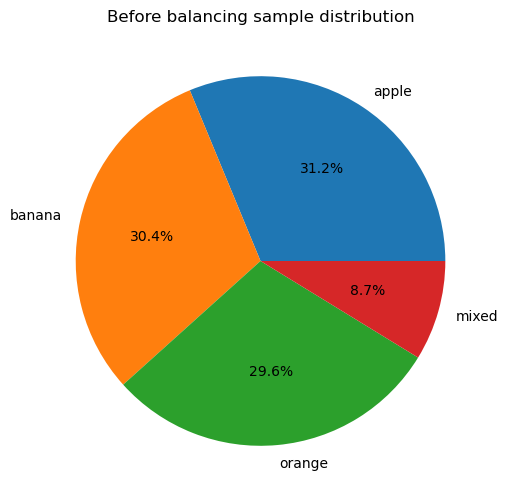

In [9]:
# extract the data from the csv file
original_balance_df = pd.read_csv(os.path.join(folder,"train_updated.csv"))

# Extract the column representing the labels
original_balance_labels = original_balance_df[["apple", "banana", "orange", "mixed"]]

# Count the frequency of each unique label
original_labels_counts = original_balance_labels.value_counts()

# Plot a pie chart to show the distribution of the data samples
plt.figure(figsize=(8, 6))
plt.pie(original_labels_counts, labels=["apple", "banana", "orange", "mixed"], autopct='%1.1f%%')
plt.title("Before balancing sample distribution")
plt.show()

### Balance the dataset

In [10]:
# Balance the dataset and perform oversampling

# get the file with the updated labels
refined_df = pd.read_csv(os.path.join(folder, "train_updated.csv"))

x_data = refined_df["fname"]
y_data = refined_df[["apple","banana","orange","mixed"]]

x_train = np.array(x_data).reshape(-1,1)
y_label = np.array(y_data)

# convert from one hot encoding to label encoding to perform random oversampling
y_label = np.argmax(y_label, axis=1)

# instantiate RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# perform random oversampling on X_train and y_train_original
x_ros, y_ros = ros.fit_resample(x_train, y_label)

# convert label encoding back to onehot encoding
onehotencoder = OneHotEncoder()
y_ros = onehotencoder.fit_transform(y_ros.reshape(-1, 1)).toarray()

# convert x and y data back to dataframe and combined
x_train_ros = pd.DataFrame(x_ros, columns=["fname"])
y_train_ros = pd.DataFrame(y_ros, columns=fruitList)
train_ros = pd.concat([x_train_ros, y_train_ros],axis=1)


# save updated file
train_ros.to_csv(os.path.join(folder, "train_refined.csv"),index=False)

# show the distribution of data
train_ros.describe()

apple      banana      orange       mixed
count  300.000000  300.000000  300.000000  300.000000
mean     0.250000    0.250000    0.250000    0.250000
std      0.433736    0.433736    0.433736    0.433736
min      0.000000    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000    0.000000
75%      0.250000    0.250000    0.250000    0.250000
max      1.000000    1.000000    1.000000    1.000000

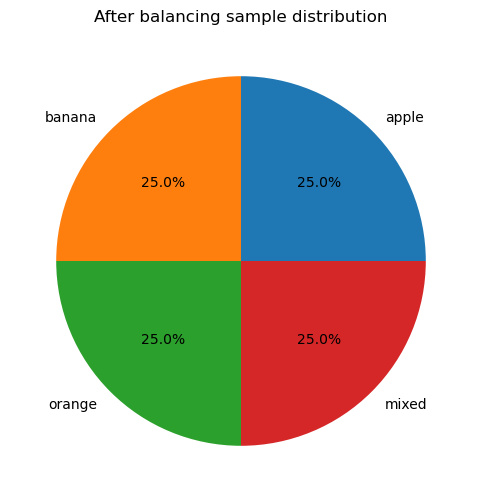

In [11]:
# Extract the column representing the labels
rebalanced_labels = train_ros[["apple", "banana", "orange", "mixed"]]

# Count the frequency of each unique label
rebalanced_labels_counts = rebalanced_labels.value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(rebalanced_labels_counts, labels=["apple", "banana", "orange", "mixed"], autopct='%1.1f%%')
plt.title("After balancing sample distribution")
plt.show()

### Train the model using the updated dataset

In [12]:
# Get the updated dataset from the train data
csv_folder = "image-info-csv/"
train_processed_fname = os.path.join(csv_folder, "train_refined.csv")
train_folder_name = "train"

# Generate the data for training and testing
x_train, x_val, y_train, y_val, x_input_shape, output_layer = prep_training_data(train_processed_fname, 
                                                 train_folder_name, validation_split, img_rescale, reshaped_size)

# Create a csv logger callback
logger_name = f"logger/train_model/02_base_model_renamed_labels-{current_time}.log"
logger = tf.keras.callbacks.CSVLogger(logger_name, separator=",", append=False)
callbacks = [earlyStopping, logger]

# Show the number of samples in the dataset
print(f"The number of data in x_train is {len(x_train)}, y_train is {len(y_train)}")
print(f"The number of data in x_validation is {len(x_val)}, y_validation is {len(y_val)}")
print(f"The number of data in x_test is {len(x_test)}, y_test is {len(y_test)}")

/Users/chanweiquan/miniforge3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The number of data in x_train is 255, y_train is 255
The number of data in x_validation is 45, y_validation is 45
The number of data in x_test is 60, y_test is 60


In [13]:
# create the model
processed_model = created_untuned_model(x_input_shape, output_layer)

# train the model
processed_model_history = train_model(processed_model, x_train = x_train, y_train = y_train
                , batch_size = batch_size, epochs = epochs
                , callbacks = callbacks, x_val=x_val, y_val=y_val)

Epoch 1/100
4/4 [==============================] - 1s 125ms/step - loss: 5.2626 - accuracy: 0.2392 - val_loss: 6.8486 - val_accuracy: 0.3556
Epoch 2/100
4/4 [==============================] - 0s 109ms/step - loss: 5.7481 - accuracy: 0.3843 - val_loss: 3.5696 - val_accuracy: 0.4000
Epoch 3/100
4/4 [==============================] - 0s 108ms/step - loss: 2.4101 - accuracy: 0.4353 - val_loss: 1.3554 - val_accuracy: 0.3556
Epoch 4/100
4/4 [==============================] - 0s 107ms/step - loss: 1.6705 - accuracy: 0.2941 - val_loss: 1.3059 - val_accuracy: 0.3556
Epoch 5/100
4/4 [==============================] - 0s 109ms/step - loss: 1.0911 - accuracy: 0.4824 - val_loss: 1.1709 - val_accuracy: 0.5333
Epoch 6/100
4/4 [==============================] - 0s 109ms/step - loss: 0.9662 - accuracy: 0.6431 - val_loss: 1.0659 - val_accuracy: 0.5778
Epoch 7/100
4/4 [==============================] - 0s 109ms/step - loss: 0.8819 - accuracy: 0.6471 - val_loss: 0.8409 - val_accuracy: 0.5556
Epoch 8/100
4

The accuracy of the untuned processed model on the test dataset is: 
2/2 [==============================] - 0s 21ms/step - loss: 0.6225 - accuracy: 0.8333
[0.6225011944770813, 0.8333333134651184] 



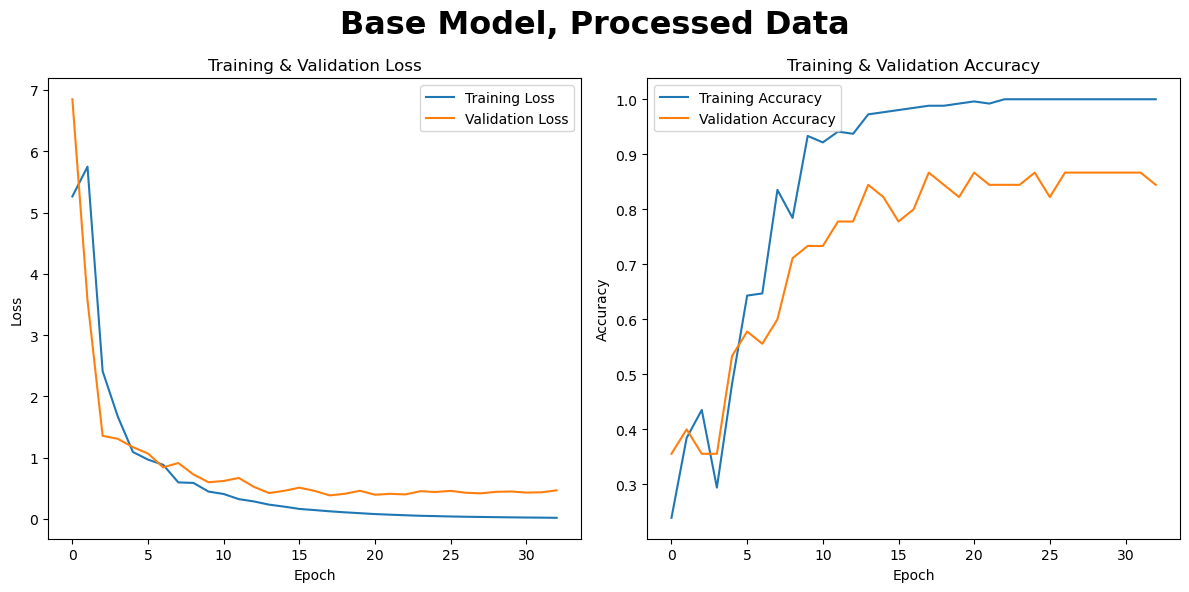

In [14]:
# Test the model
print("The accuracy of the untuned processed model on the test dataset is: ")
processed_data_model_results = test_model(processed_model, x_test, y_test)
print(processed_data_model_results, "\n")
    
show_logger_plot(logger_name, "Base Model, Processed Data")

Based on the observed results, it can be seen that there is a slight improvement in the test accuracy which is expected as introducing more data samples and correcting the label will can help to improve the accuracy of the model.<br>
However, the graph above shows that the training accuracy curve shows signs of overfitting. One possible explanation can be that the current data samples is limited in variety and is also due to insufficient data samples. As such, data augmentation can potentially help to address this problem to introduce more diversity and patterns when training the model, making the model more robust in predictions.

# Part 3 - Performing Data Augmentation

This section focuses on using data augmentation to enhance the model's accuracy. Data augmentation will be performed by using an image data generator. The training log, which shows the feature exploration is presented below. 

With reference to the images provided in the train and test dataset, the following image augmentation techniques are chosen to augment the data and to investigate if it will result in an improvement in training the model. The explanation for the chosen methods are provided below:
- rotation_range: the fruits provided in the dataset provided are not always at the same orientation and should be tested with different rotation angles
- width_shift_range: some of the fruits are not located directly in the centre and shifting the positions horizontally may provide more useful training data
- height_shift_range: adjusting the position of the fruits vertically can help to increase more diversity in the training images and may provide better results
- shear_range: applying different shear angles can help to simulate different angles of the fruits
- zoom_range: some of the fruits are zoomed in and zooming in/out of the fruits may help the model to better identify the fruits
- horizontal_flip: flipping the images horizontally can help to introduce flipped orientation, helping the model to better identify it


In [15]:
def plot_training_logger(filepath, figsize=(15, 10)):
    # Sort the folders in ascending order to plot in order if any
    folders = sorted([logFile for logFile in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, logFile))])

    # get the full file paths
    for folderName in folders:
        folderPath = os.path.join(filepath, folderName)
        files = os.path.join(folderPath, "*.log")
        all_df = []
        values = []

        # get the folder name using string manipulation
        for log in glob.glob(files):
            start_index = log.find('&') + 1
            end_index = log.find('&', start_index)
            value = log[start_index:end_index]
            df = pd.read_csv(log)
            values.append(value)
            all_df.append(df)

        # plot all the graphs
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=figsize)

        # Iterate through each dataframe
        for i, df in enumerate(all_df):
            # Plot training loss
            ax1.plot(df['epoch'], df['loss'], label=f'Training Loss: {values[i]}')

            # Plot validation loss
            ax2.plot(df['epoch'], df['val_loss'], label=f'Validation Loss: {values[i]}')

            # Plot training accuracy
            ax3.plot(df['epoch'], df['accuracy'], label=f'Training Accuracy: {values[i]}')

            # Plot validation accuracy
            ax4.plot(df['epoch'], df['val_accuracy'], label=f'Validation Accuracy: {values[i]}')

        # Set the plot labels and titles for training loss
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Training Loss")
        ax1.set_title("Training Loss")

        # Set the plot labels and titles for validation loss
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Validation Loss")
        ax2.set_title("Validation Loss")

        # Set the plot labels and titles for training accuracy
        ax3.set_xlabel("Epochs")
        ax3.set_ylabel("Training Accuracy")
        ax3.set_title("Training Accuracy")

        # Set the plot labels and titles for validation accuracy
        ax4.set_xlabel("Epochs")
        ax4.set_ylabel("Validation Accuracy")
        ax4.set_title("Validation Accuracy")

        # Add a legend to each plot
        ax1.legend(title=f"{folderName}", loc='upper right')
        ax2.legend(title=f"{folderName}", loc='upper right')
        ax3.legend(title=f"{folderName}", loc='lower right')
        ax4.legend(title=f"{folderName}", loc='lower right')

        # Adjust the spacing between plots
        plt.tight_layout()

        # Display the plots
        plt.show()


## Training Log: Feature Exploration

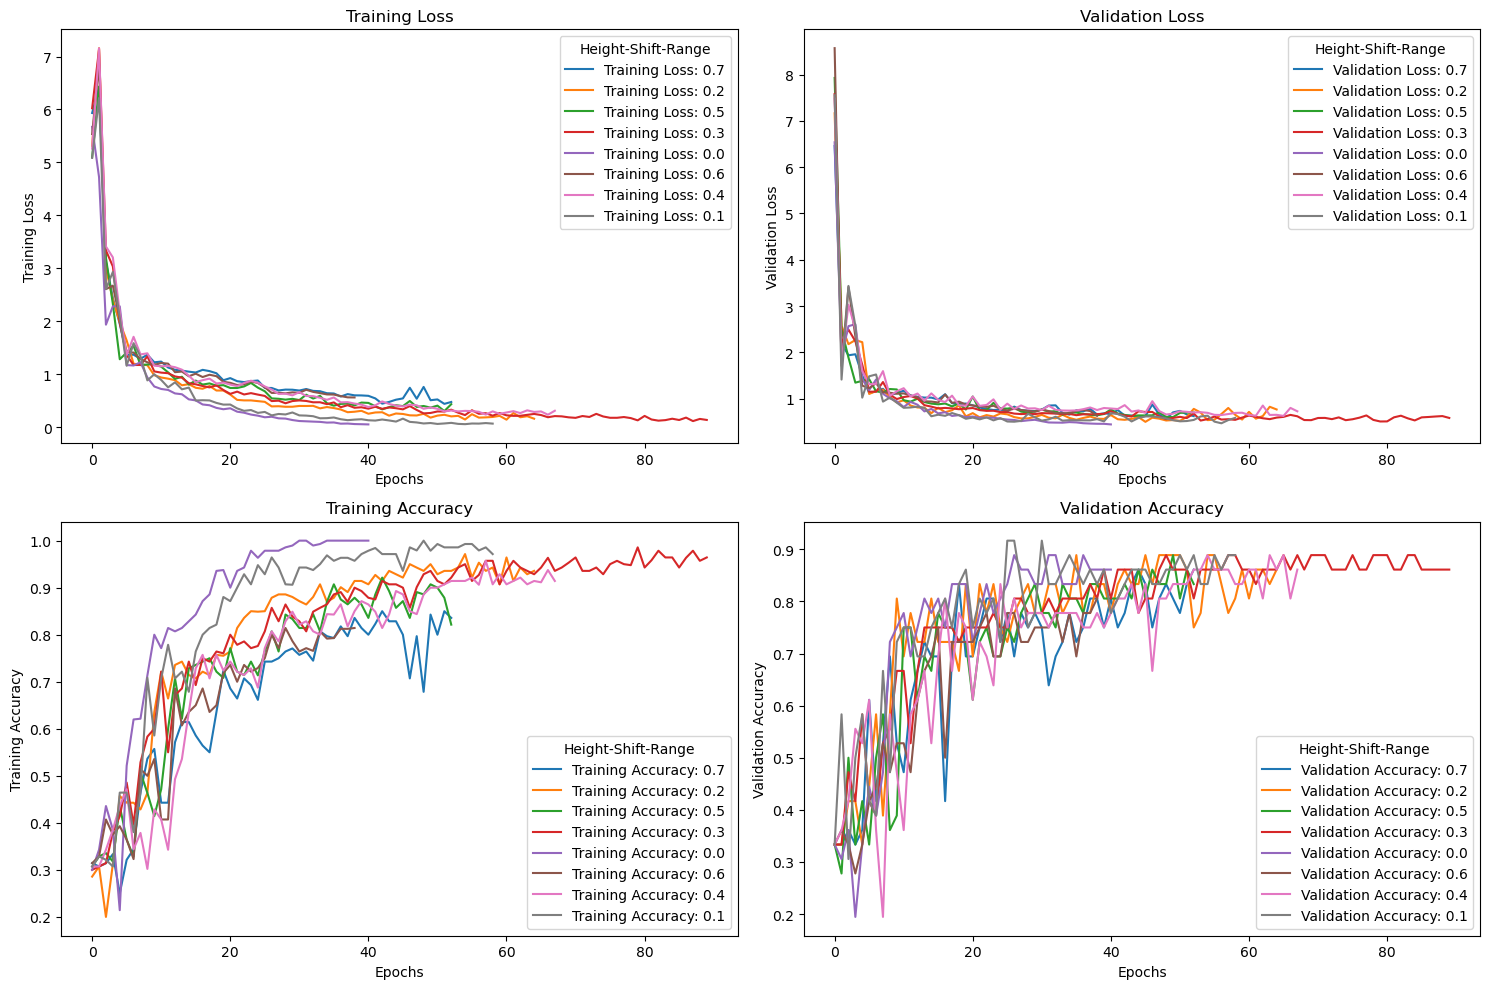

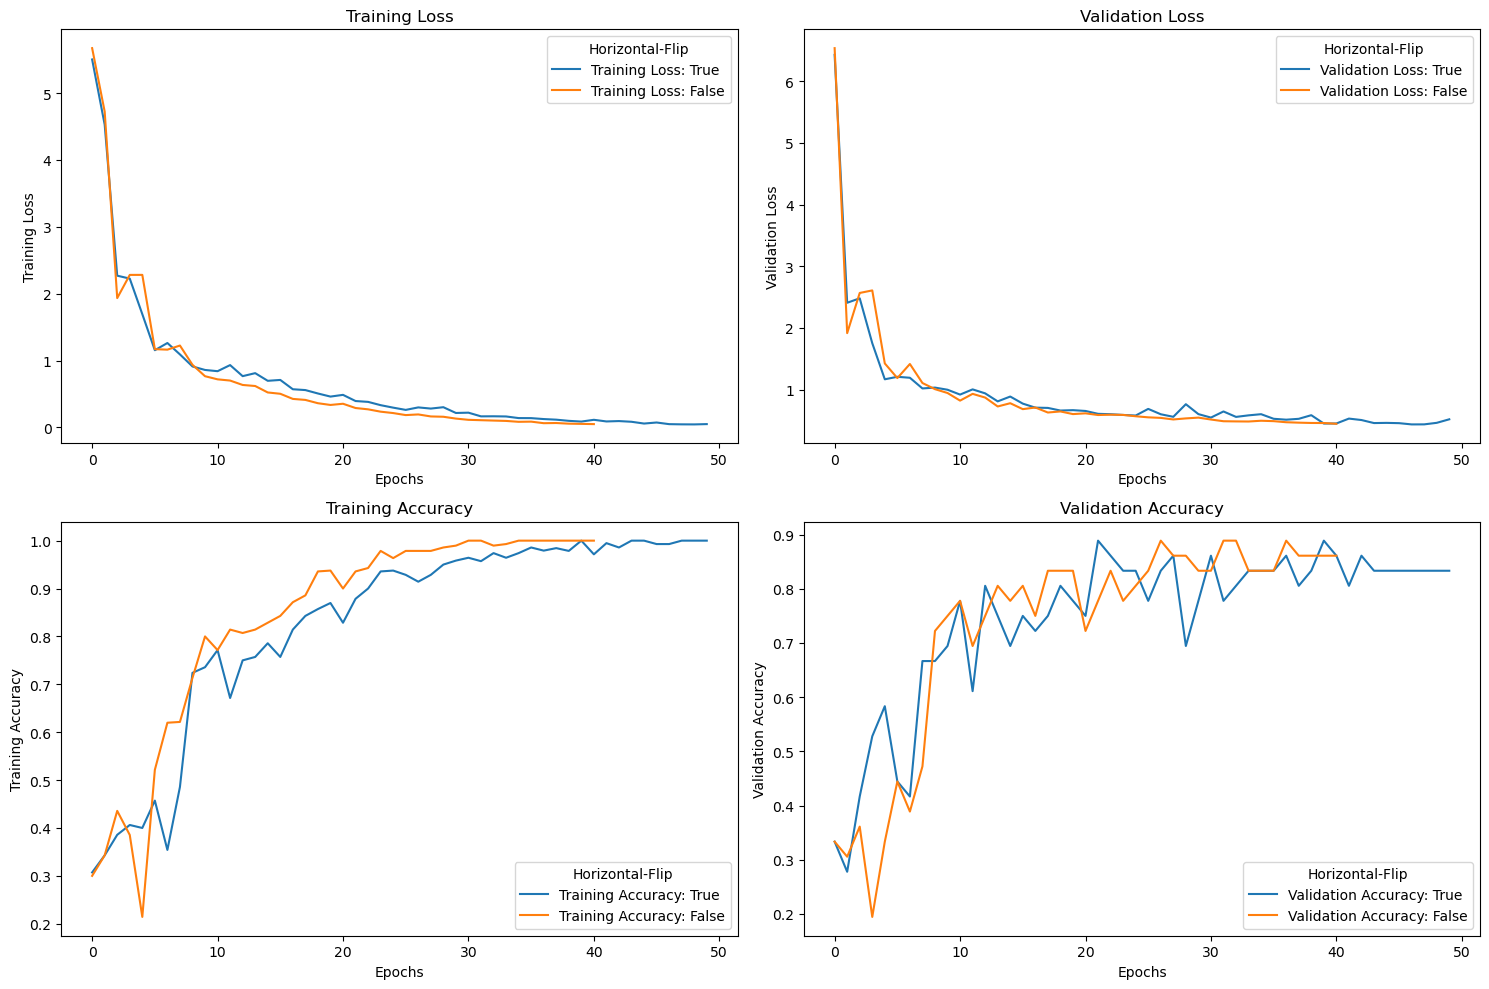

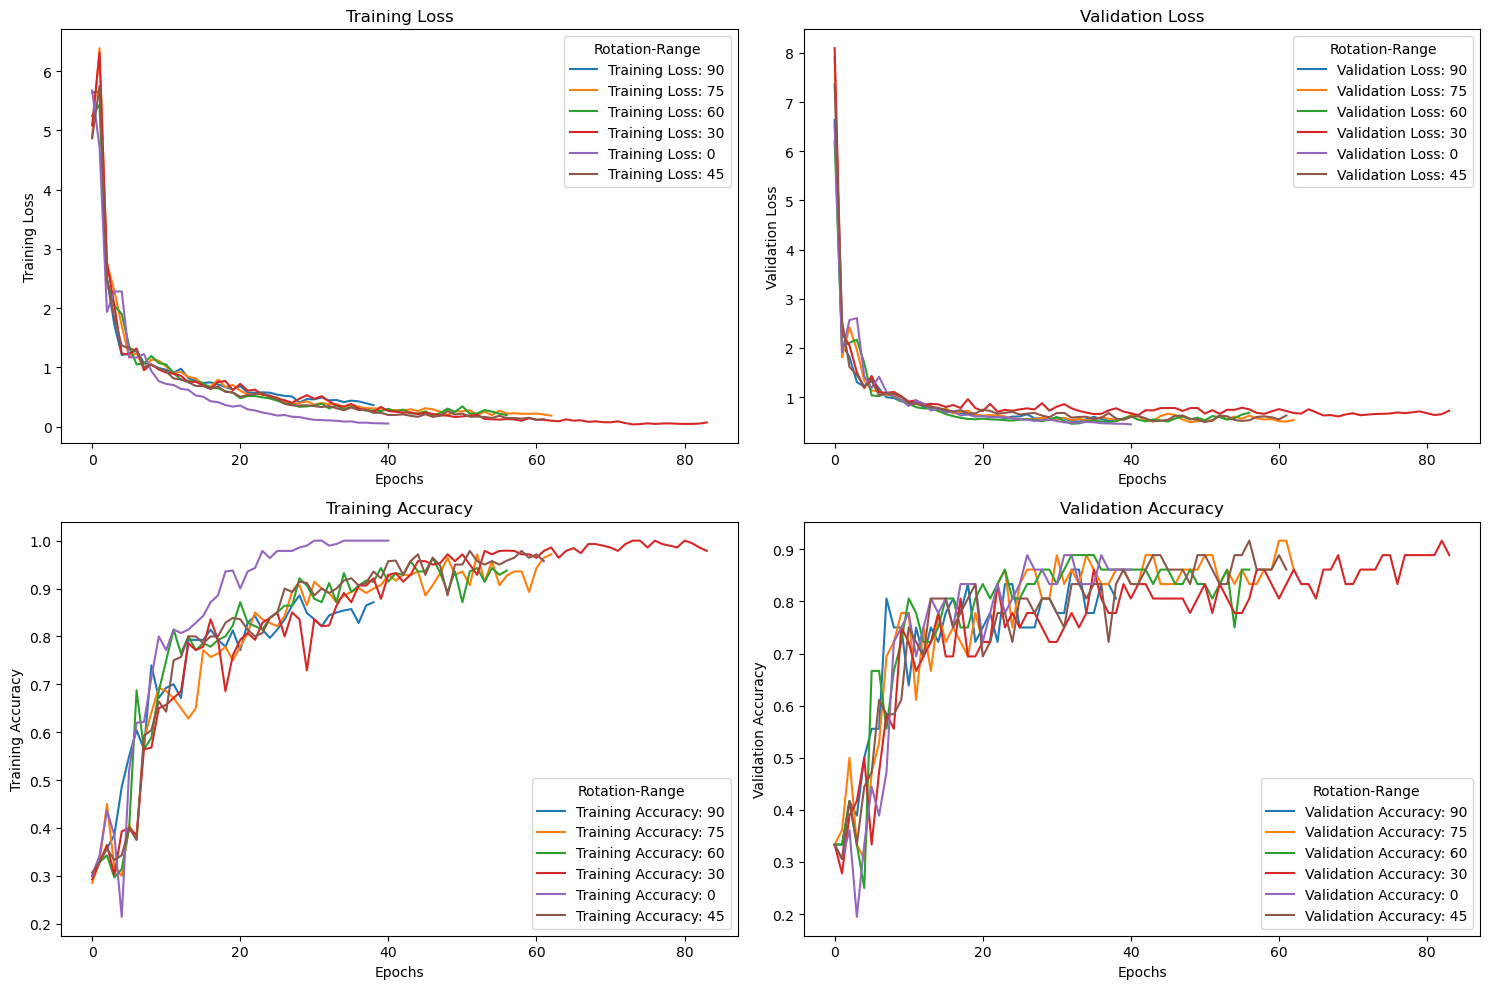

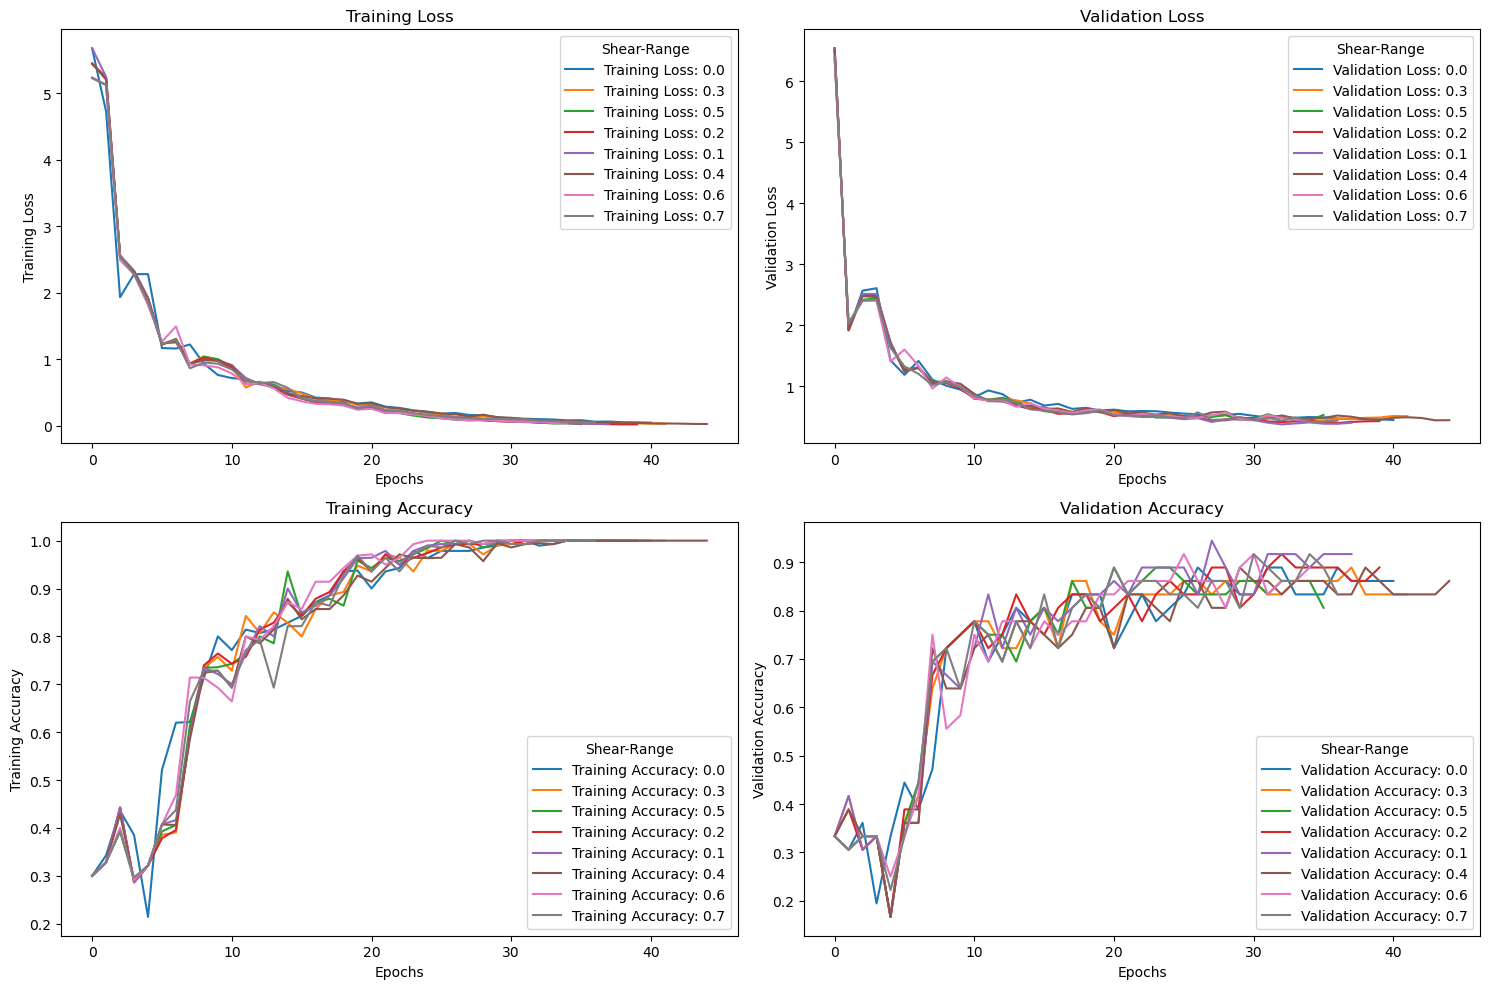

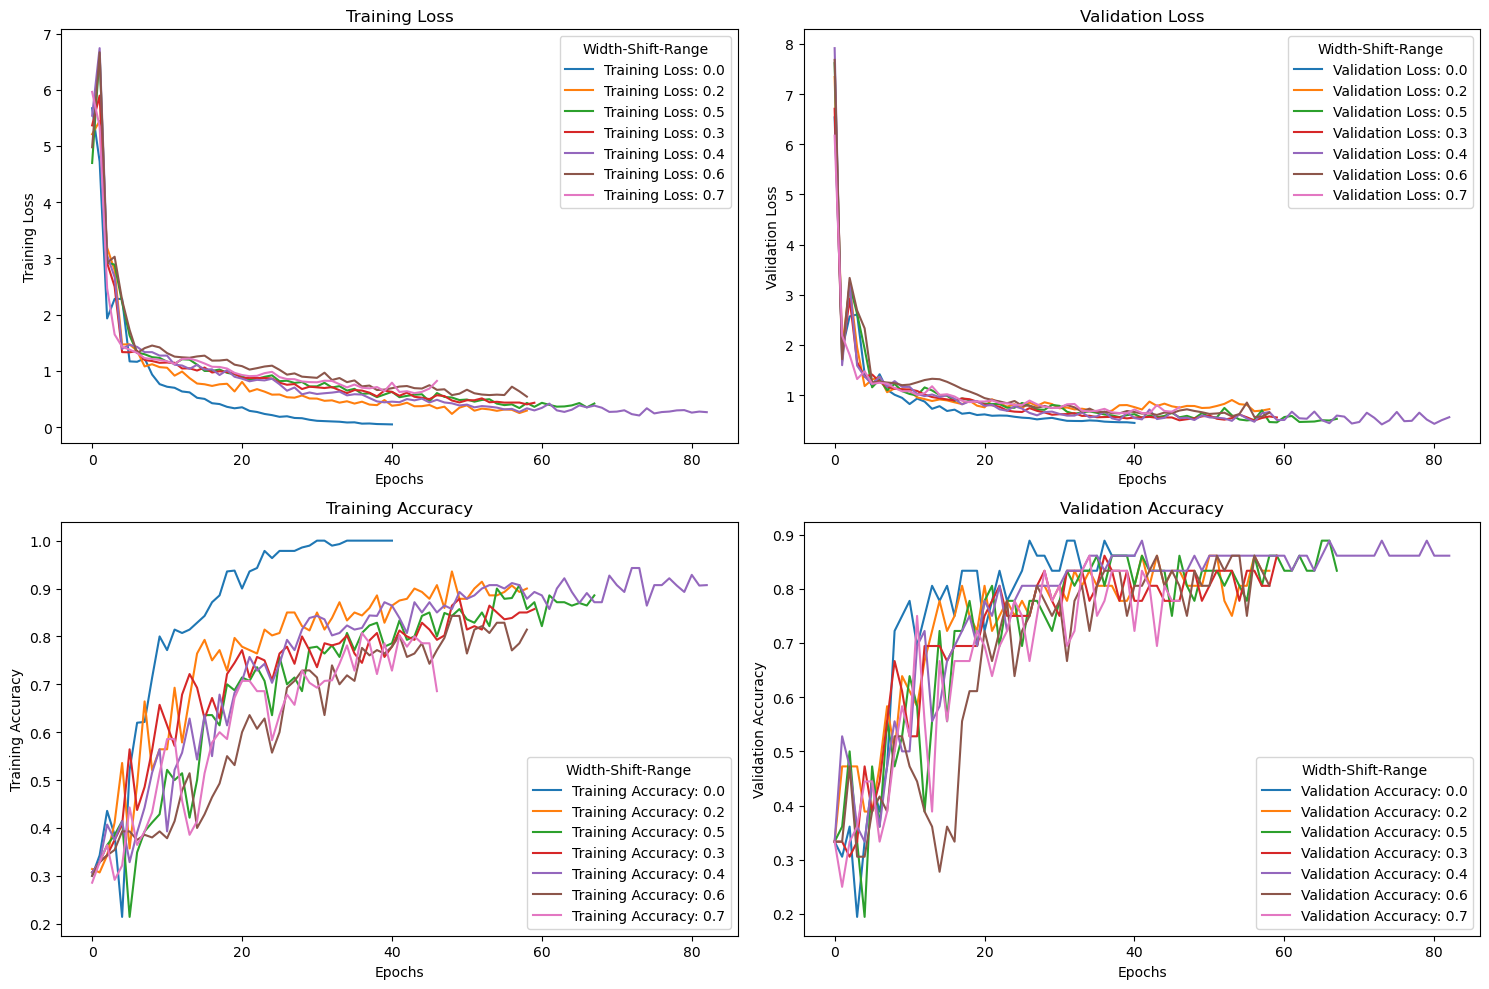

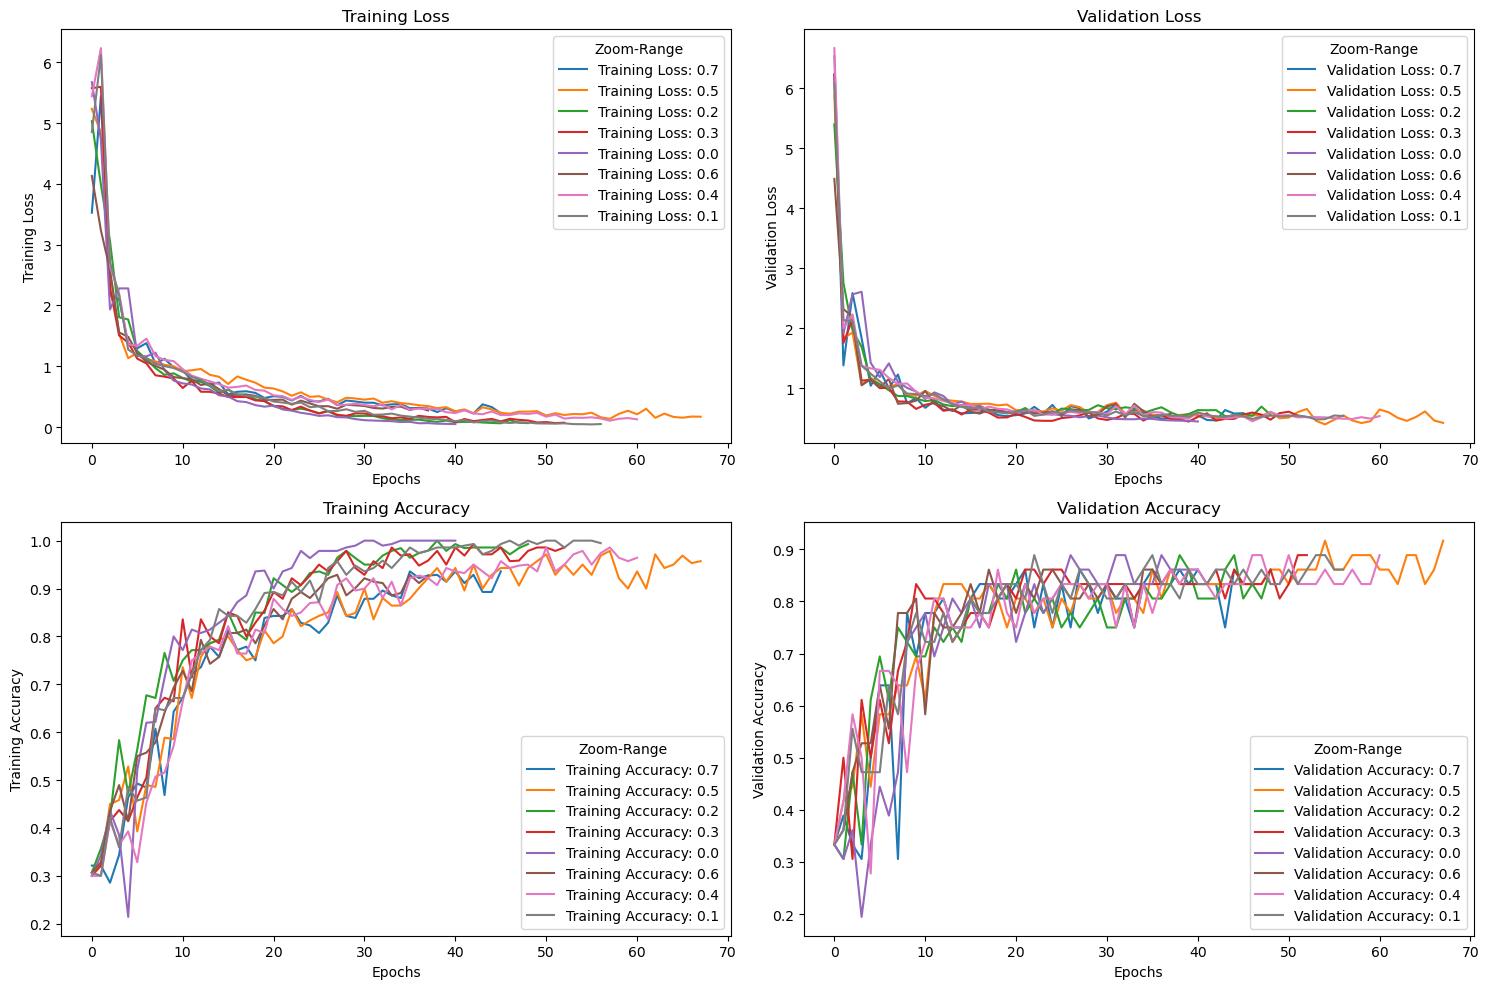

In [16]:
aug_log_dir = os.path.join(os.getcwd(),"logger","data_aug_params")
plot_training_logger(aug_log_dir)

Using the findings from the training log, the significant features that contributes to an improvement in the model accuracy will be futher investigated. Using those values, various combinations of these features will be explored and the final configuration is shown below.

In [17]:
# Data Augmentation
def augment_data(x_train, y_train, x_val, y_val, batch_size):
    """
    Augments the training data by data augmentation to generate more data
    Parameters:
    x_train (np.array): the input training data for the cnn
    y_train (np.array): the output training data for the cnn
    x_val (np.array): the input validation data for the cnn
    y_val (np.array): the input validation data for the cnn
    batch_size (int): the batch size to use for the model
    Returns: 
    tuple: A tuple containing two `tf.keras.preprocessing.image.ImageDataGenerator` objects.
    The first object generates batches of augmented training data, the second object generates batches of 
    validation data.
    """
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.1
        )
    
    datagen.fit(x_train)

    # Use the data generator to generate batches of augmented data
    train_augment_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
    # no augmentation will be performed on the validation data
    val_augment_generator = ImageDataGenerator().flow(x_val, y_val, batch_size=batch_size)

    return train_augment_generator, val_augment_generator


def train_aug_gen_model(model, train_augment_generator, batch_size, epochs, callbacks
                        , val_augment_generator, steps_per_epoch):
    """
    Trains the model using augmented data generated by an ImageDataGenerator.
    Parameters:
    model (tf.keras.Model): the model to be trained
    train_augment_generator (tf.keras.preprocessing.image.ImageDataGenerator): the data generator for augmented training data
    batch_size (int): the batch size for training
    epochs (int): the number of times to train the model
    callbacks (tf.keras.callbacks.Callback): the callbacks to use during training
    val_augment_generator (tf.keras.preprocessing.image.ImageDataGenerator): the data generator for augmented validation data
    steps_per_epoch (int): the number of iterations to be in each epoch
    Returns:
    history object containing training/validation loss and accuracy
    """
    # Fit the model using the generator
    history = model.fit(
        x=train_augment_generator,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_augment_generator,
        steps_per_epoch=steps_per_epoch
    )

    return history

In [18]:
# Create a csv logger callback
aug_untuned_logger_name = f"logger/train_model/03-untuned_augmented_data_model-{current_time}.log"
aug_untuned_logger = tf.keras.callbacks.CSVLogger(aug_untuned_logger_name, separator=",", append=False)

# Create a list of the loggers to fit in the model
untuned_aug_callbacks = [earlyStopping, aug_untuned_logger]

# Show the number of samples in the dataset
print(f"The number of data in x_train is {len(x_train)}, y_train is {len(y_train)}")
print(f"The number of data in x_validation is {len(x_val)}, y_validation is {len(y_val)}")
print(f"The number of data in x_test is {len(x_test)}, y_test is {len(y_test)}")

The number of data in x_train is 255, y_train is 255
The number of data in x_validation is 45, y_validation is 45
The number of data in x_test is 60, y_test is 60


In [19]:
# generate steps per epoch
num_of_samples = len(x_train)
untuned_steps_per_epoch = num_of_samples // batch_size

# augment the data
train_augment_generator, val_augment_generator = augment_data(x_train, y_train, x_val, y_val, batch_size)

# create the model and train
aug_untuned_data_model = created_untuned_model(x_input_shape, output_layer)
aug_untuned_data_history = train_aug_gen_model(aug_untuned_data_model, train_augment_generator, batch_size, epochs
                                       ,untuned_aug_callbacks, val_augment_generator, untuned_steps_per_epoch)

Epoch 1/100
3/3 [==============================] - 1s 143ms/step - loss: 3.0769 - accuracy: 0.2984 - val_loss: 8.6923 - val_accuracy: 0.2222
Epoch 2/100
3/3 [==============================] - 0s 119ms/step - loss: 7.7042 - accuracy: 0.2565 - val_loss: 5.0820 - val_accuracy: 0.3111
Epoch 3/100
3/3 [==============================] - 0s 119ms/step - loss: 3.8624 - accuracy: 0.3141 - val_loss: 3.5839 - val_accuracy: 0.2667
Epoch 4/100
3/3 [==============================] - 0s 118ms/step - loss: 4.0360 - accuracy: 0.2292 - val_loss: 1.3246 - val_accuracy: 0.4444
Epoch 5/100
3/3 [==============================] - 0s 118ms/step - loss: 2.2334 - accuracy: 0.3298 - val_loss: 1.9815 - val_accuracy: 0.2444
Epoch 6/100
3/3 [==============================] - 0s 118ms/step - loss: 1.6334 - accuracy: 0.3037 - val_loss: 1.8181 - val_accuracy: 0.2444
Epoch 7/100
3/3 [==============================] - 0s 118ms/step - loss: 1.6671 - accuracy: 0.3854 - val_loss: 1.2609 - val_accuracy: 0.4222
Epoch 8/100
3

Epoch 59/100
3/3 [==============================] - 0s 121ms/step - loss: 0.2571 - accuracy: 0.8953 - val_loss: 0.8386 - val_accuracy: 0.8444
Epoch 60/100
3/3 [==============================] - 0s 120ms/step - loss: 0.2374 - accuracy: 0.9267 - val_loss: 1.0097 - val_accuracy: 0.8444
Epoch 61/100
3/3 [==============================] - 0s 121ms/step - loss: 0.2425 - accuracy: 0.9058 - val_loss: 1.0735 - val_accuracy: 0.8000
Epoch 62/100
3/3 [==============================] - 0s 121ms/step - loss: 0.2193 - accuracy: 0.9215 - val_loss: 0.9589 - val_accuracy: 0.8222
Epoch 63/100
3/3 [==============================] - 0s 119ms/step - loss: 0.1937 - accuracy: 0.9424 - val_loss: 0.8656 - val_accuracy: 0.8667
Epoch 64/100
3/3 [==============================] - 0s 121ms/step - loss: 0.1854 - accuracy: 0.9686 - val_loss: 0.8471 - val_accuracy: 0.8667
Epoch 65/100
3/3 [==============================] - 0s 121ms/step - loss: 0.2275 - accuracy: 0.9267 - val_loss: 0.9464 - val_accuracy: 0.8667
Epoch 

The accuracy of the untuned augmented data model on the test dataset is: 
2/2 [==============================] - 0s 21ms/step - loss: 1.0683 - accuracy: 0.8833
[1.0682934522628784, 0.8833333253860474] 



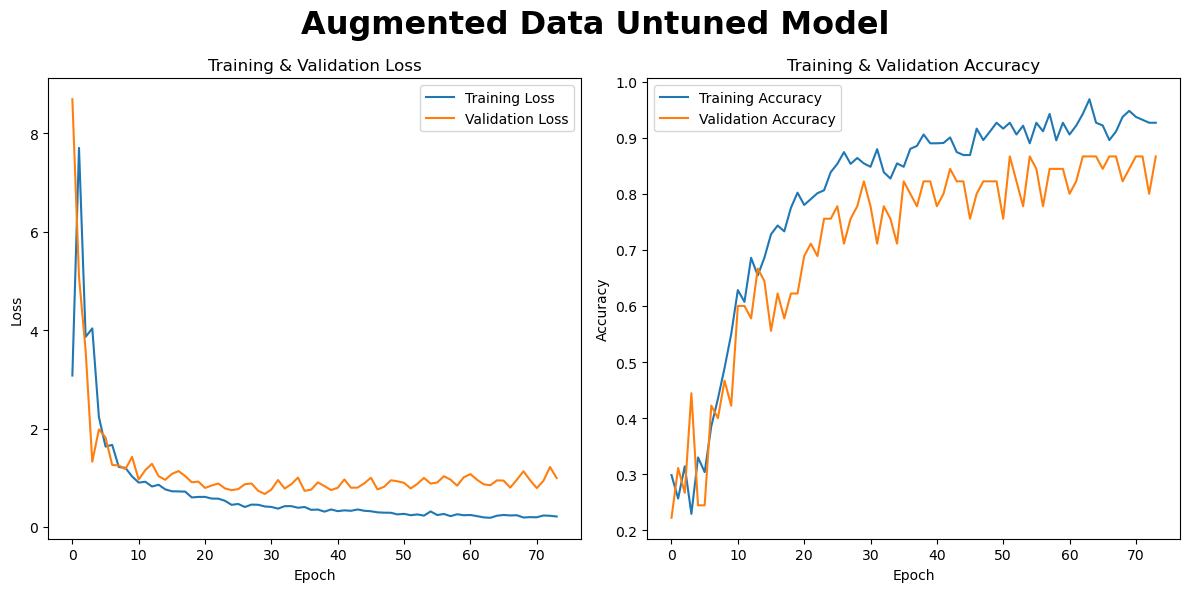

In [20]:
# test the model
print("The accuracy of the untuned augmented data model on the test dataset is: ")
aug_data_untuned_model = test_model(aug_untuned_data_model, x_test, y_test)
print(aug_data_untuned_model, "\n")

show_logger_plot(aug_untuned_logger_name, "Augmented Data Untuned Model")

From the results above, it can be seen that there is an improvement in the training, validation and test accuracy. Furthermore, by comparing the training and validation curves, it can be observed that there is less overfit in comparison to the graphs shown in part 1 and part 2. This shows that using data augmentation helps to reduce overfitting by introducing more data when training the model, leading the model to generalise well to new data. <br>

In the final section, the cnn model will be futhered tuned, and exploring which model architecture and hyperparameters are well suited for the cnn image classifier.

# Part 4 - Tuning the model architecture, hyperparameter tuning and conclusion

In this section, the model architecture will be refined to ensure that there is a good fit. Hyperparameter tuning will also be performed to optimise the model's performance. The training log which shows the exploration of the hyperparameters is provided below. The model will be fine-tuned in sequentially, following the training sequence as indicated in the graphs below.

The hyperparameters that are tuned are shown below:
1) Batch Size: It is the number of samples that are passed to the model during each training iteration
2) Reshaped Size: It is the dimensions of the data that has been resized to match the model's input requirements. The dimensions of the reshaped value can affect the data as a very small reshaped size can lead to loss in data.
3) Number of Convolutional Layers: The number of convolutional layers show the depth of the model and can help the model to learn more complex patterns and to capture more features.
4) Kernel Size: Choosing the right kernel size can help the model to extract the relevant features using the right scale.
5) Convolutional Filters: The number of filters can help the model capture more diverse and discriminative features, improving object recognition and aids in better recognising objects
6) Max Pooling Layer Strides: It can help the model to better retain the relevant spatial information while also downsampling the input which helps to preserve spatial information
7) Max Pooling Layer Pool Size: It can help the model to better retain the relevant spatial information while reduce the dimensions by summarising the downsampling the data
8) Max Pooling Layer Pool Padding: It can help to retain information at the edges of the images during max pooling and help to preserve information to be used in model training
9) Number of Hidden Layers: It can help to improve the models ability to learn more complex patterns
10) Number of Neurons: Similar to the number of hidden layers, the number of neurons will affect the model's ability to learn more complex patterns
11) Activation Functions: It helps to introduce non-linearity in the model and can allow it to capture complex relationships and enhance the model's learning capabilities
12) Optimizer: Choosing the right optimizer will enable the model to learning better and have faster convergence speeds, generalisation of models.
13) Learning Rate: It helps to control the step size during gradient descent and helps the model converge faster and avoid getting stuck in suboptimal solutions.
14) Dropout Layer: It helps to regularise the model by randomly dropping neurons during the training process and reduce overfitting in the model


## Hyperparameter tuning log


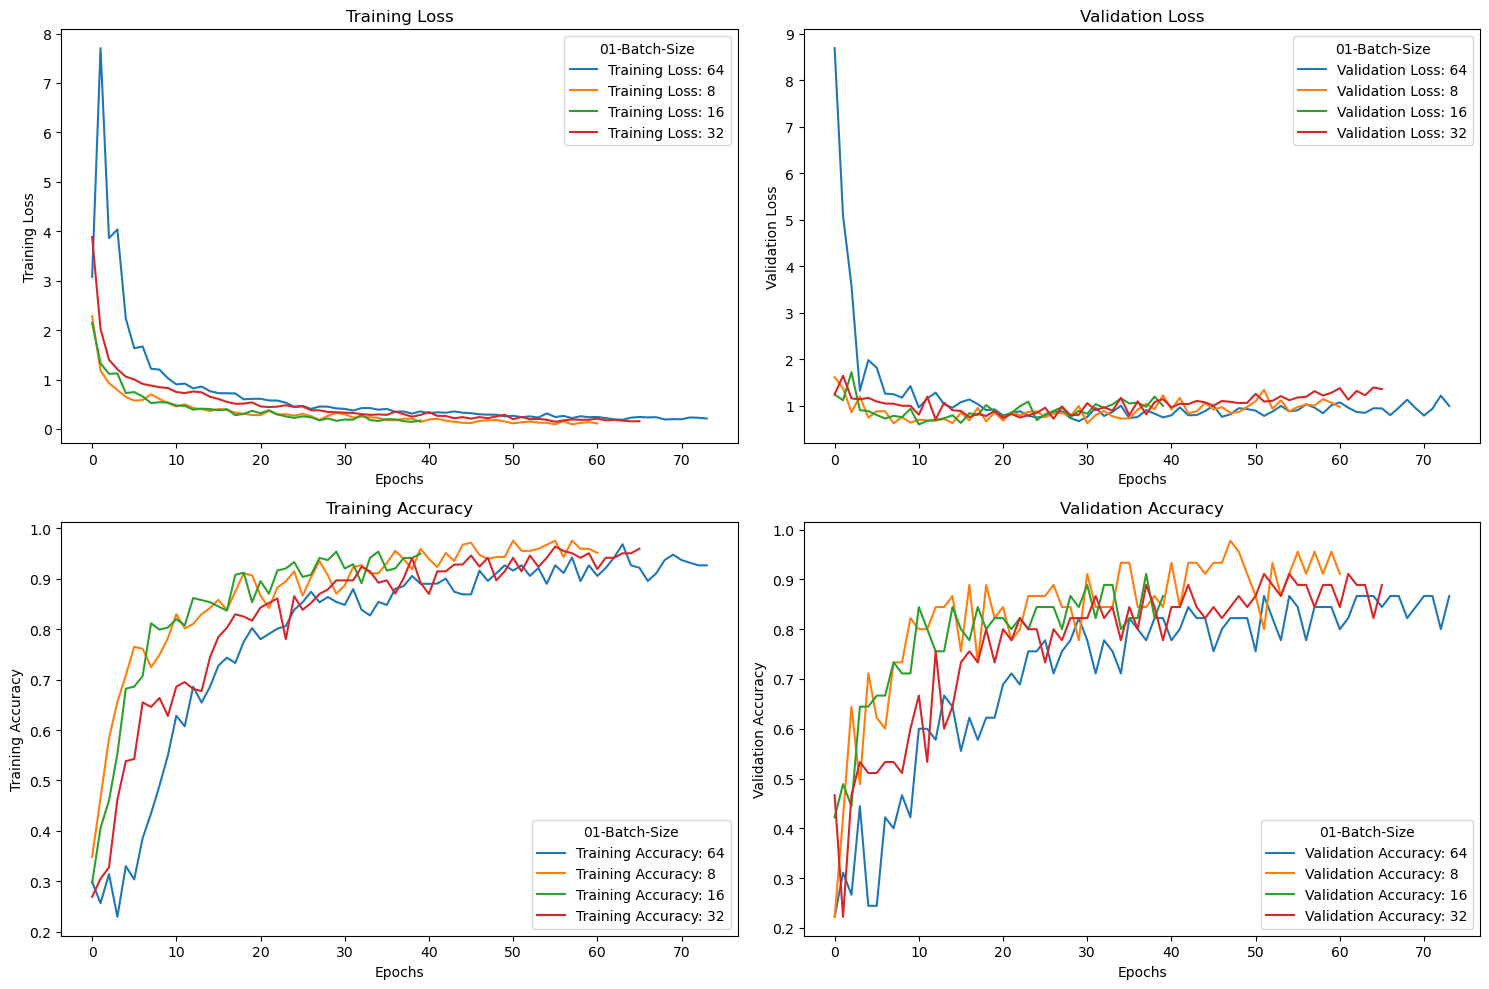

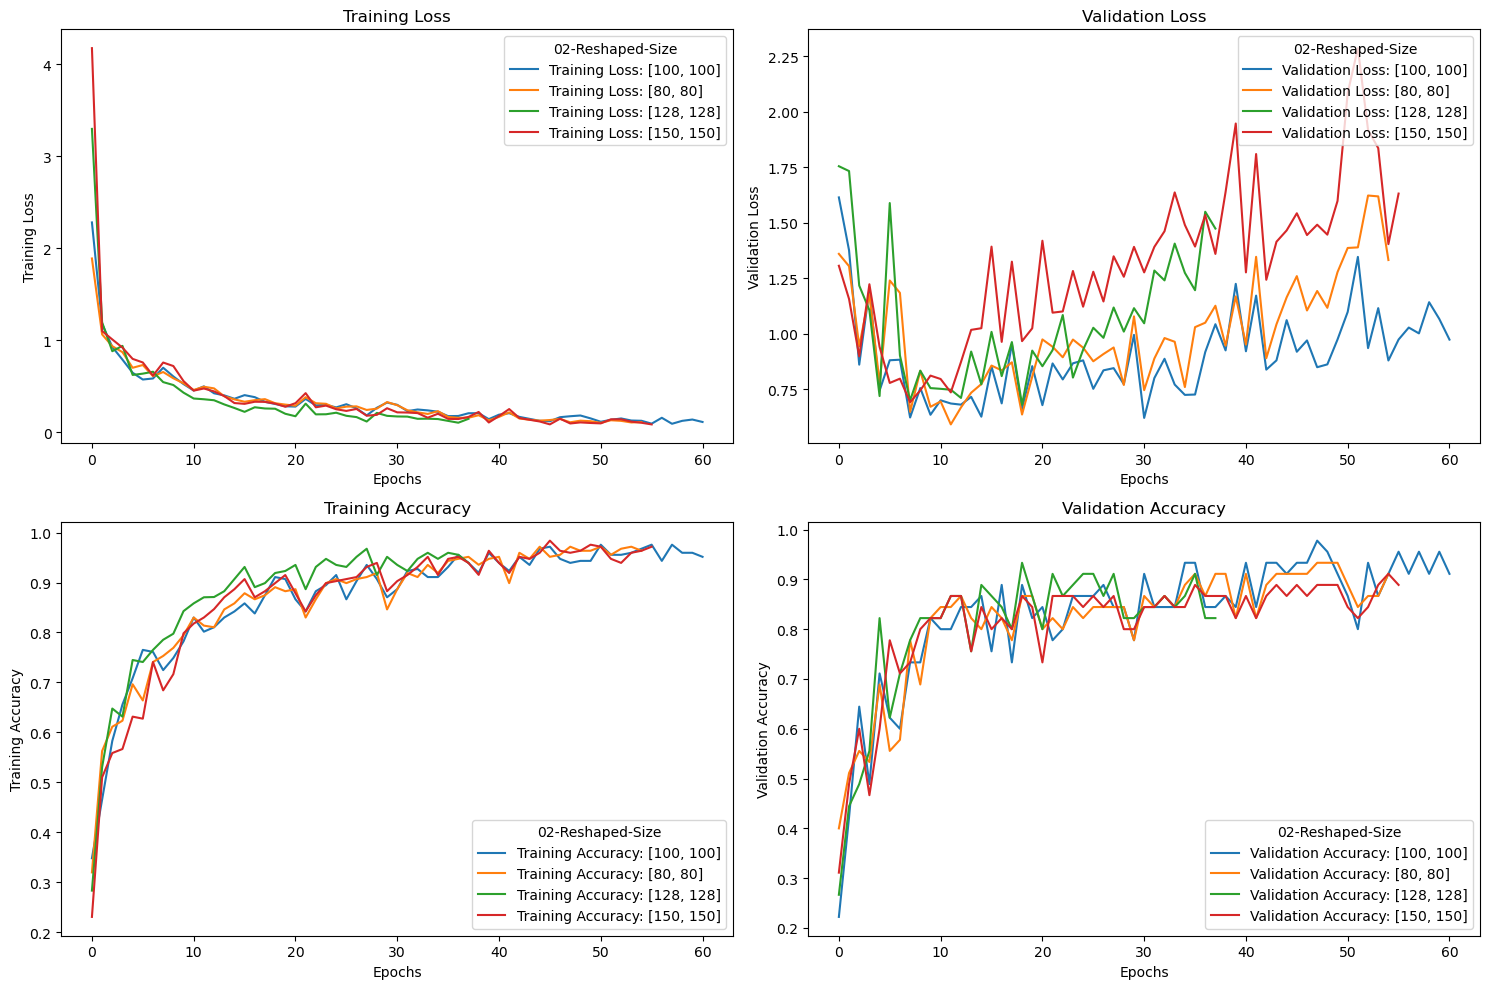

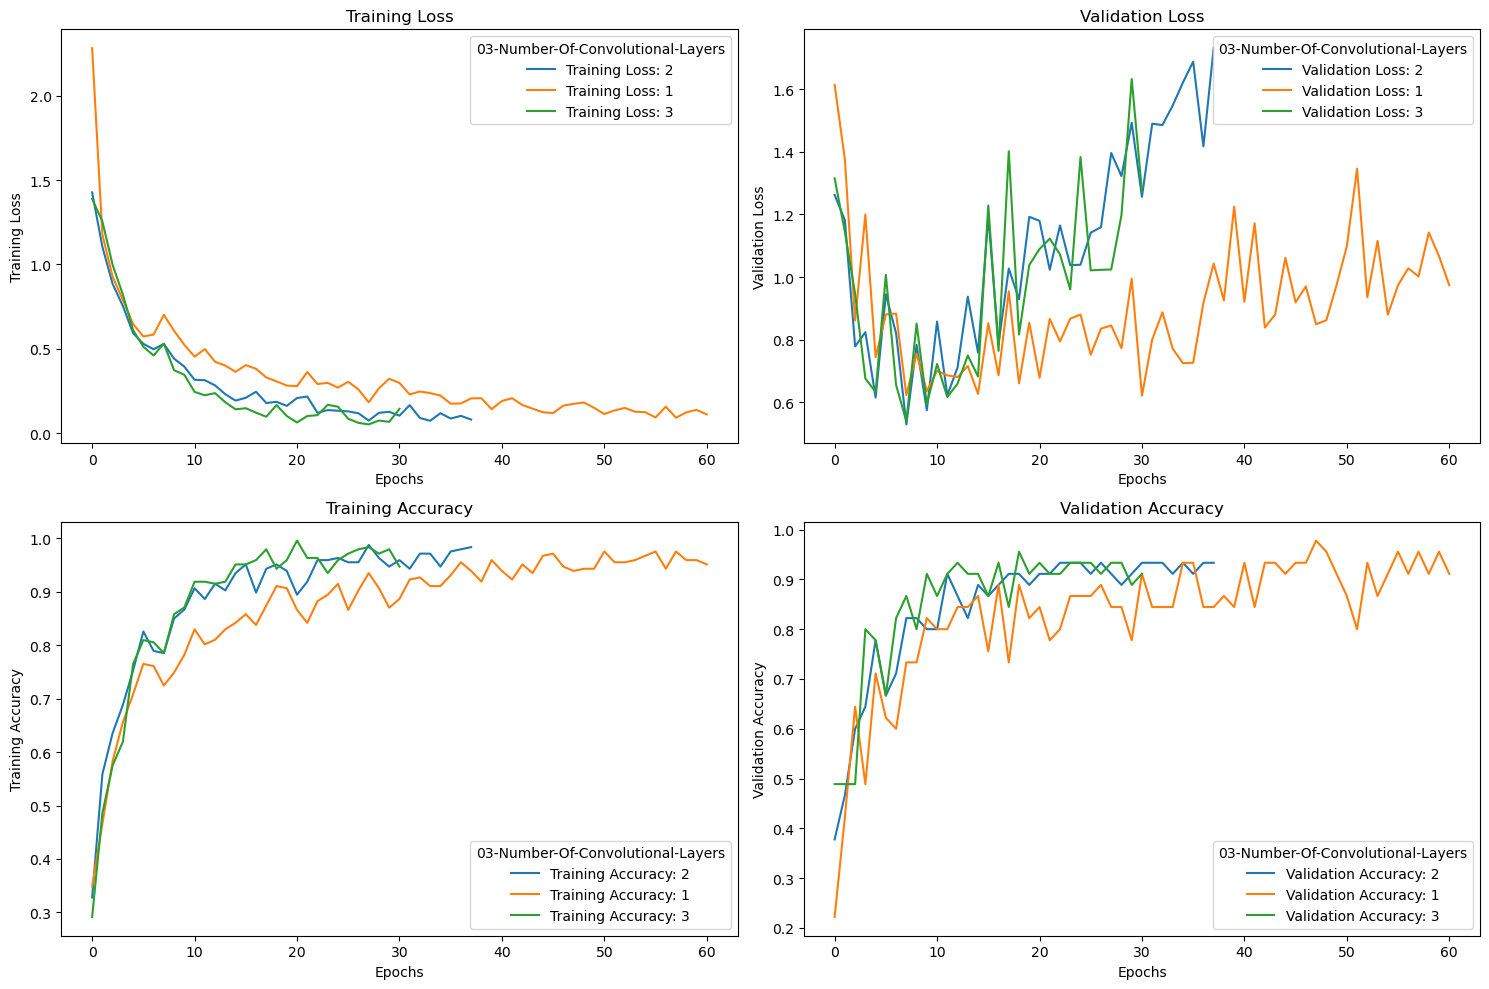

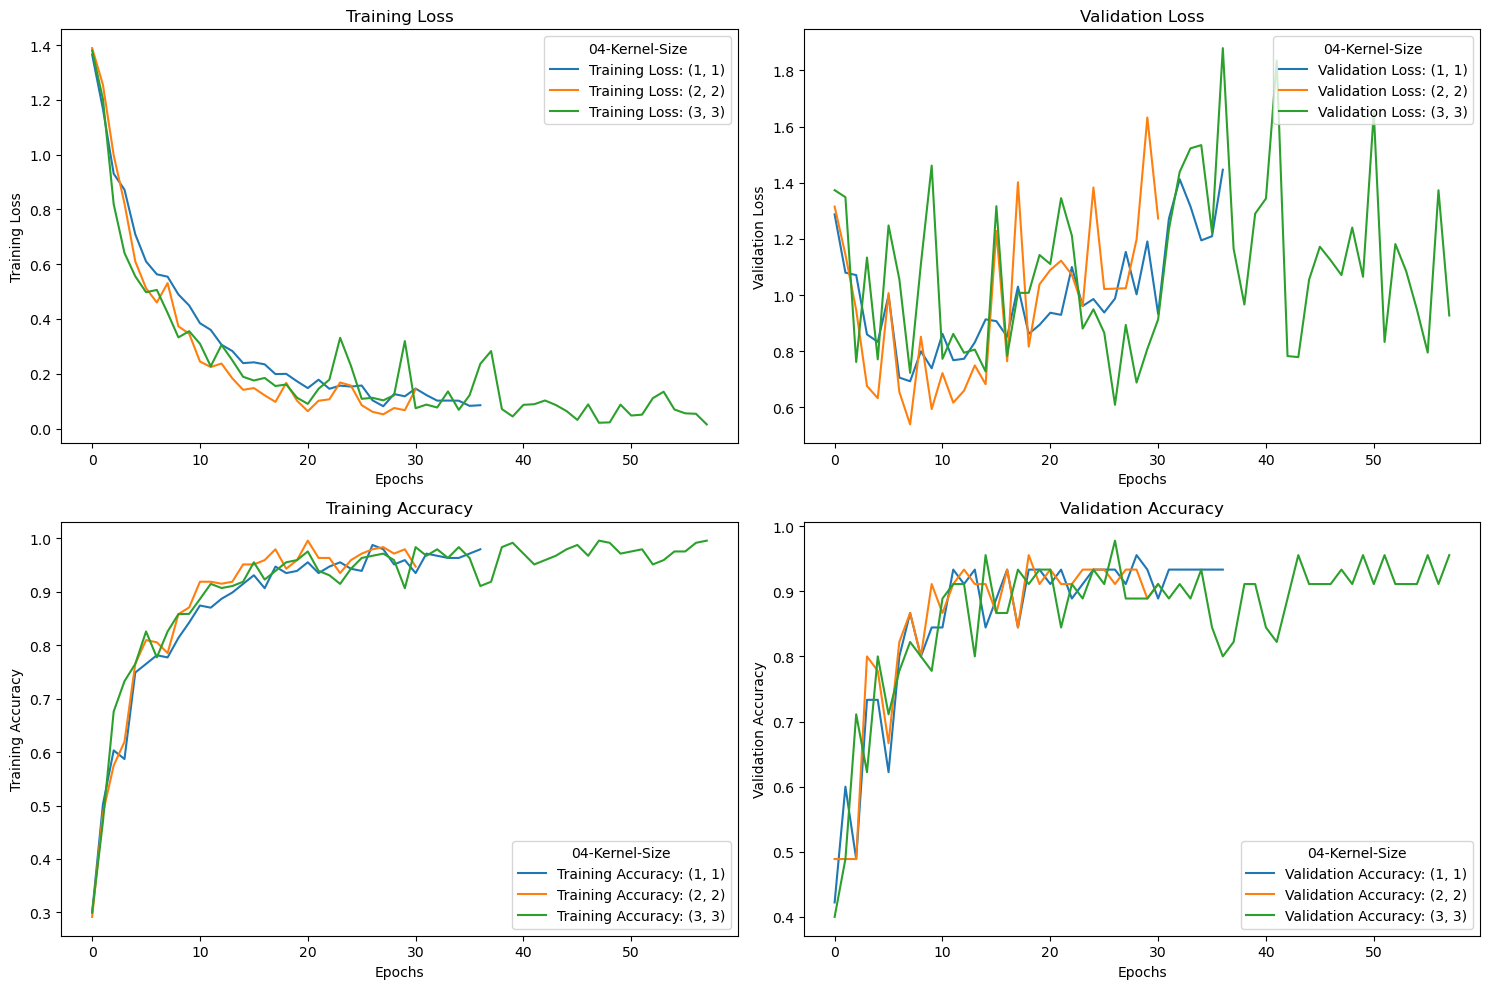

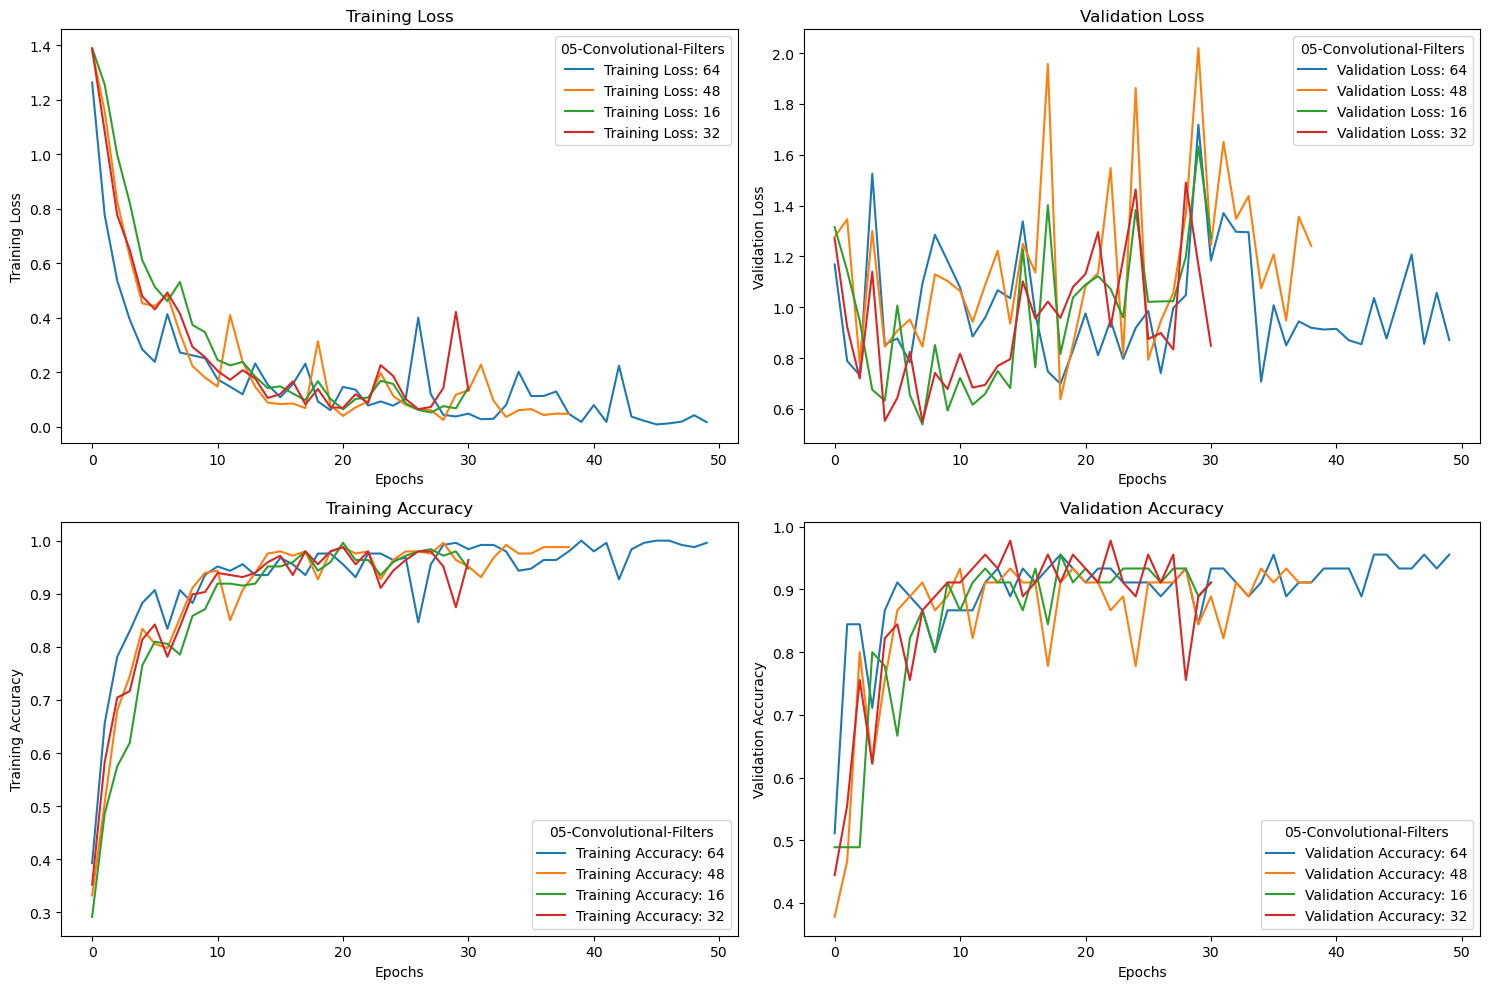

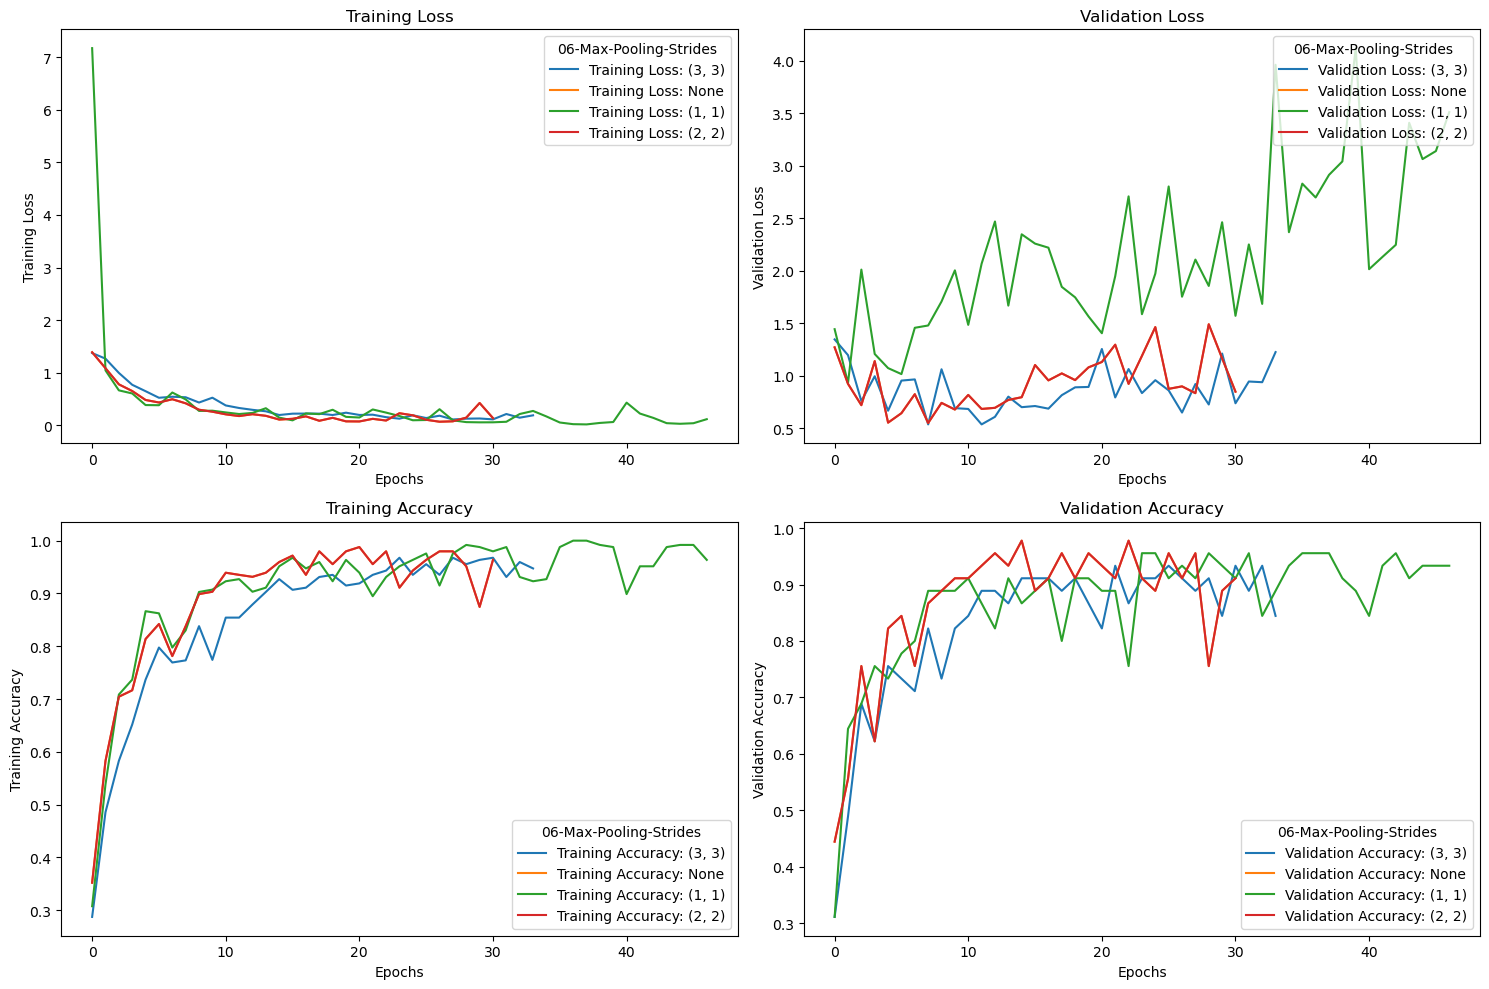

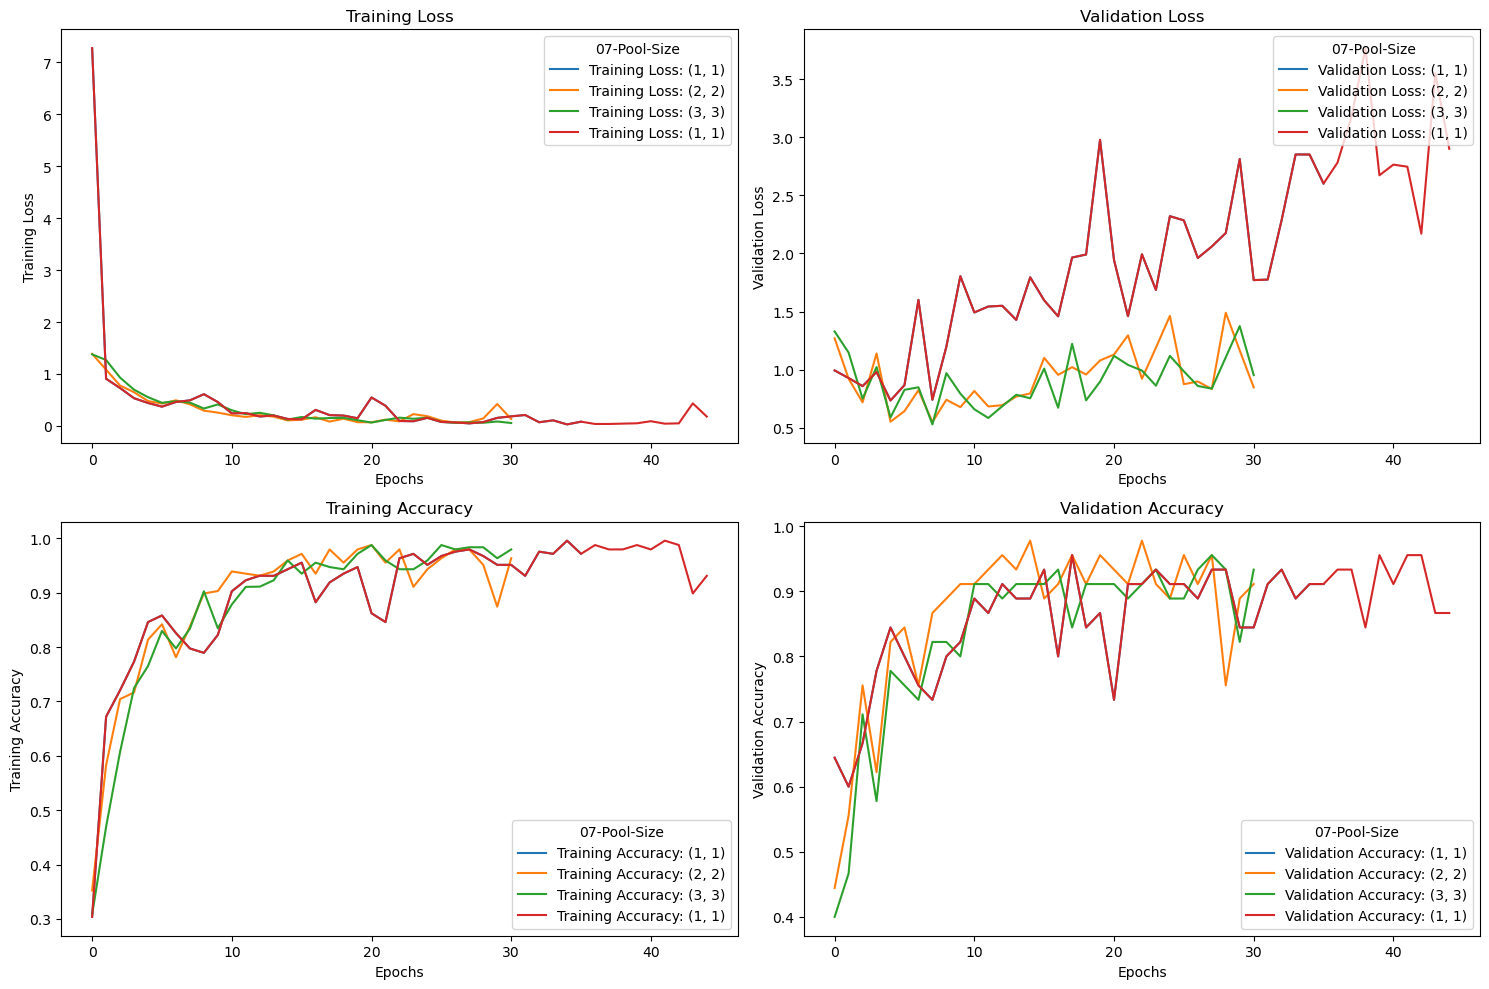

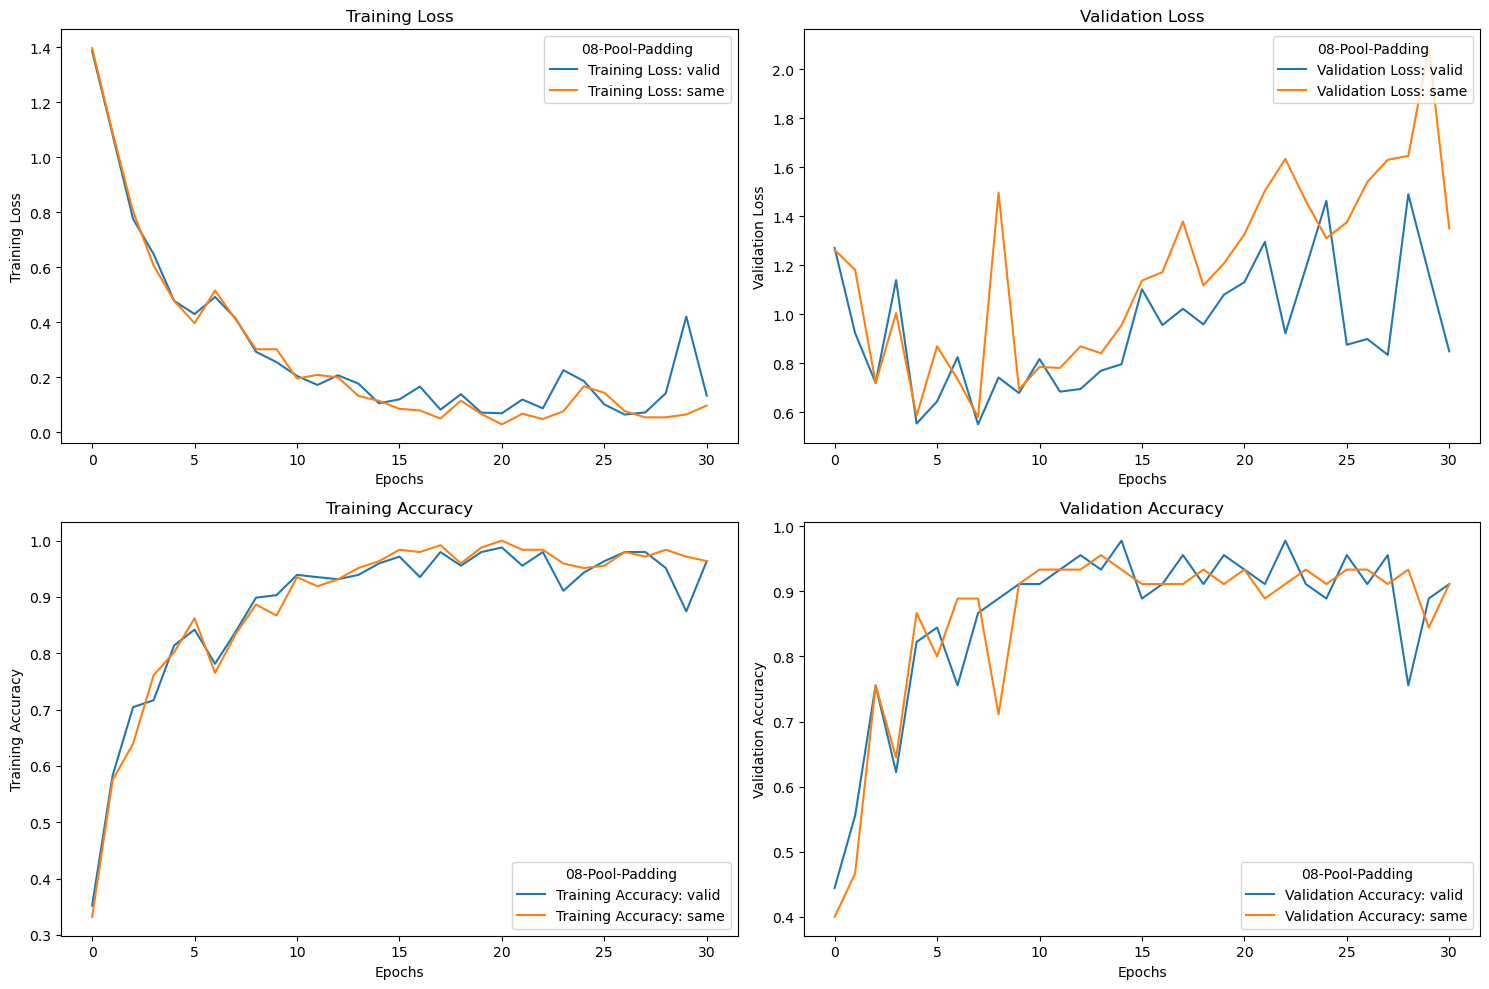

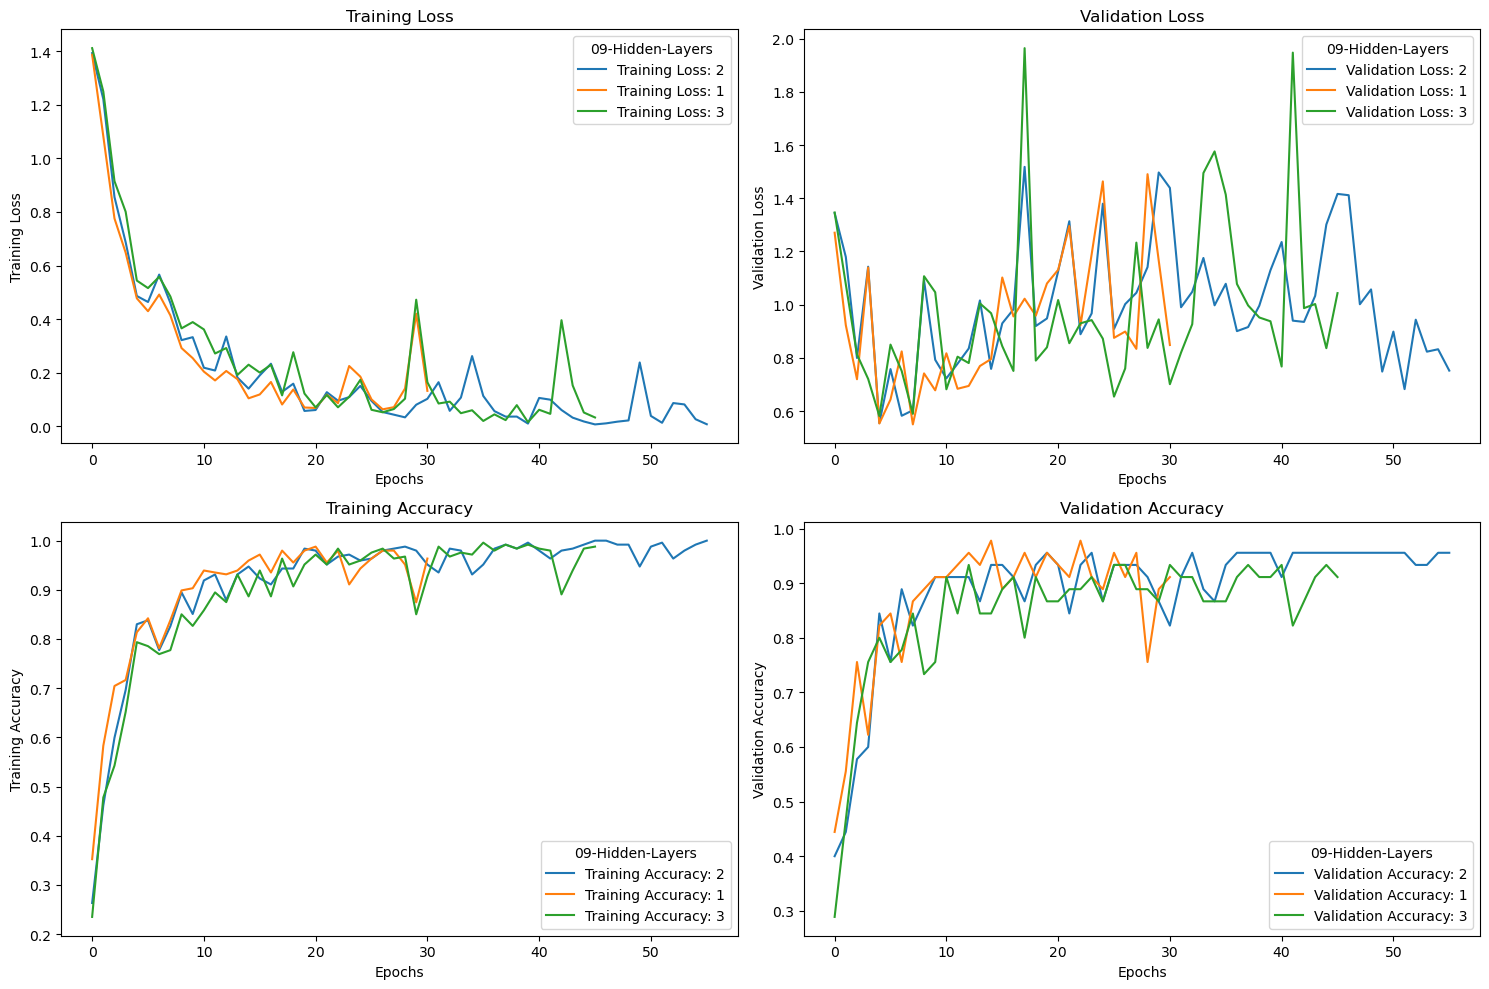

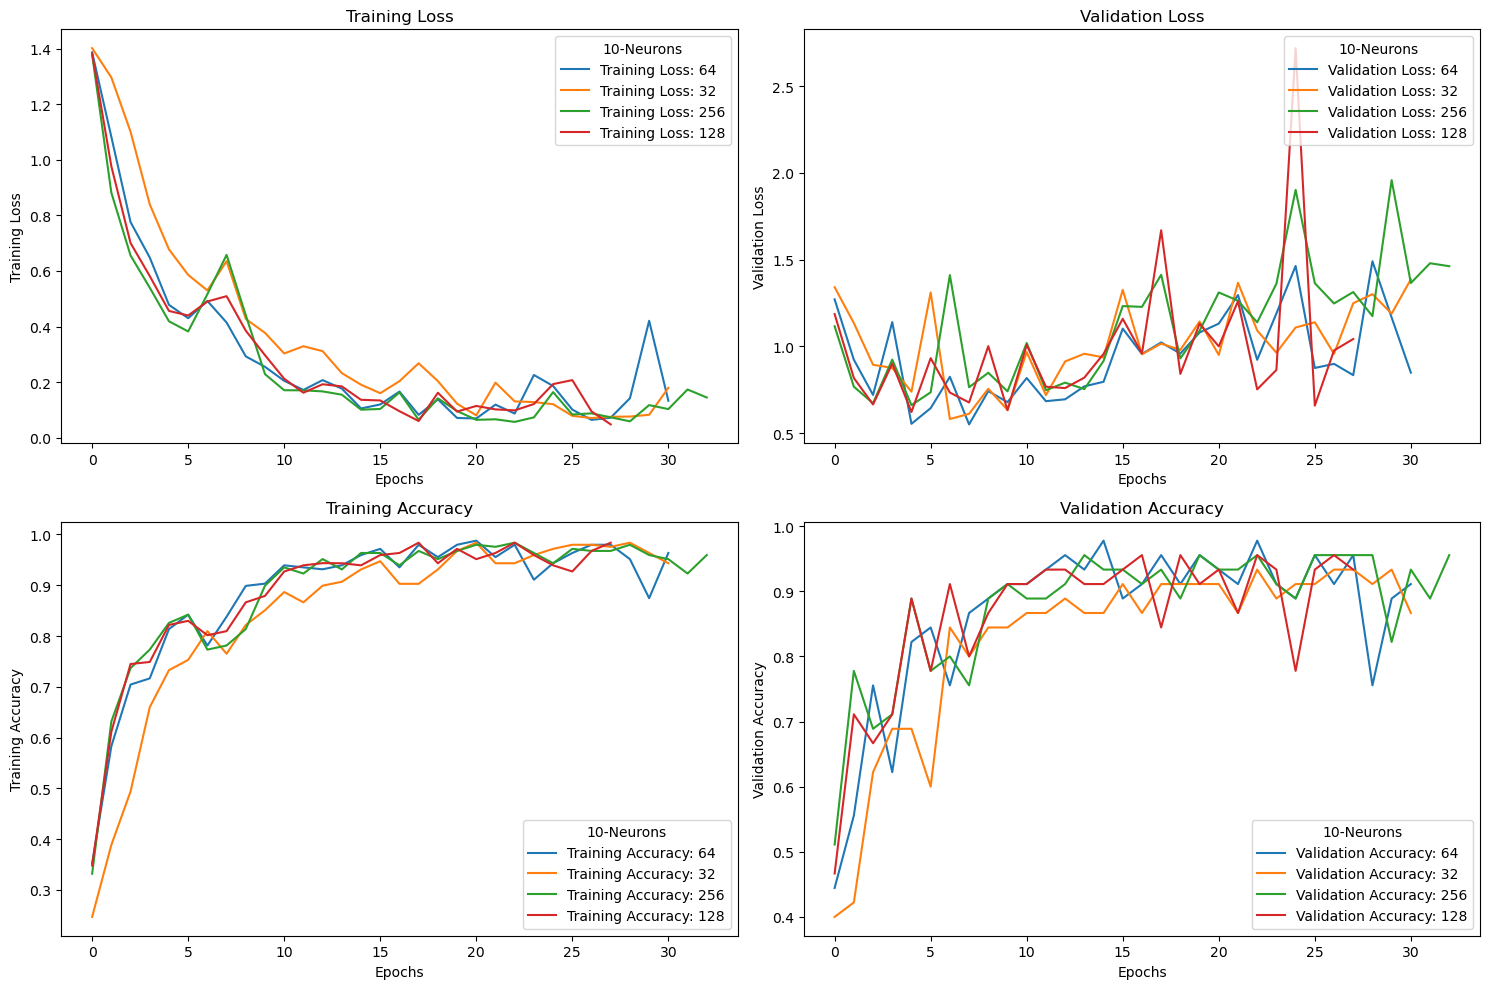

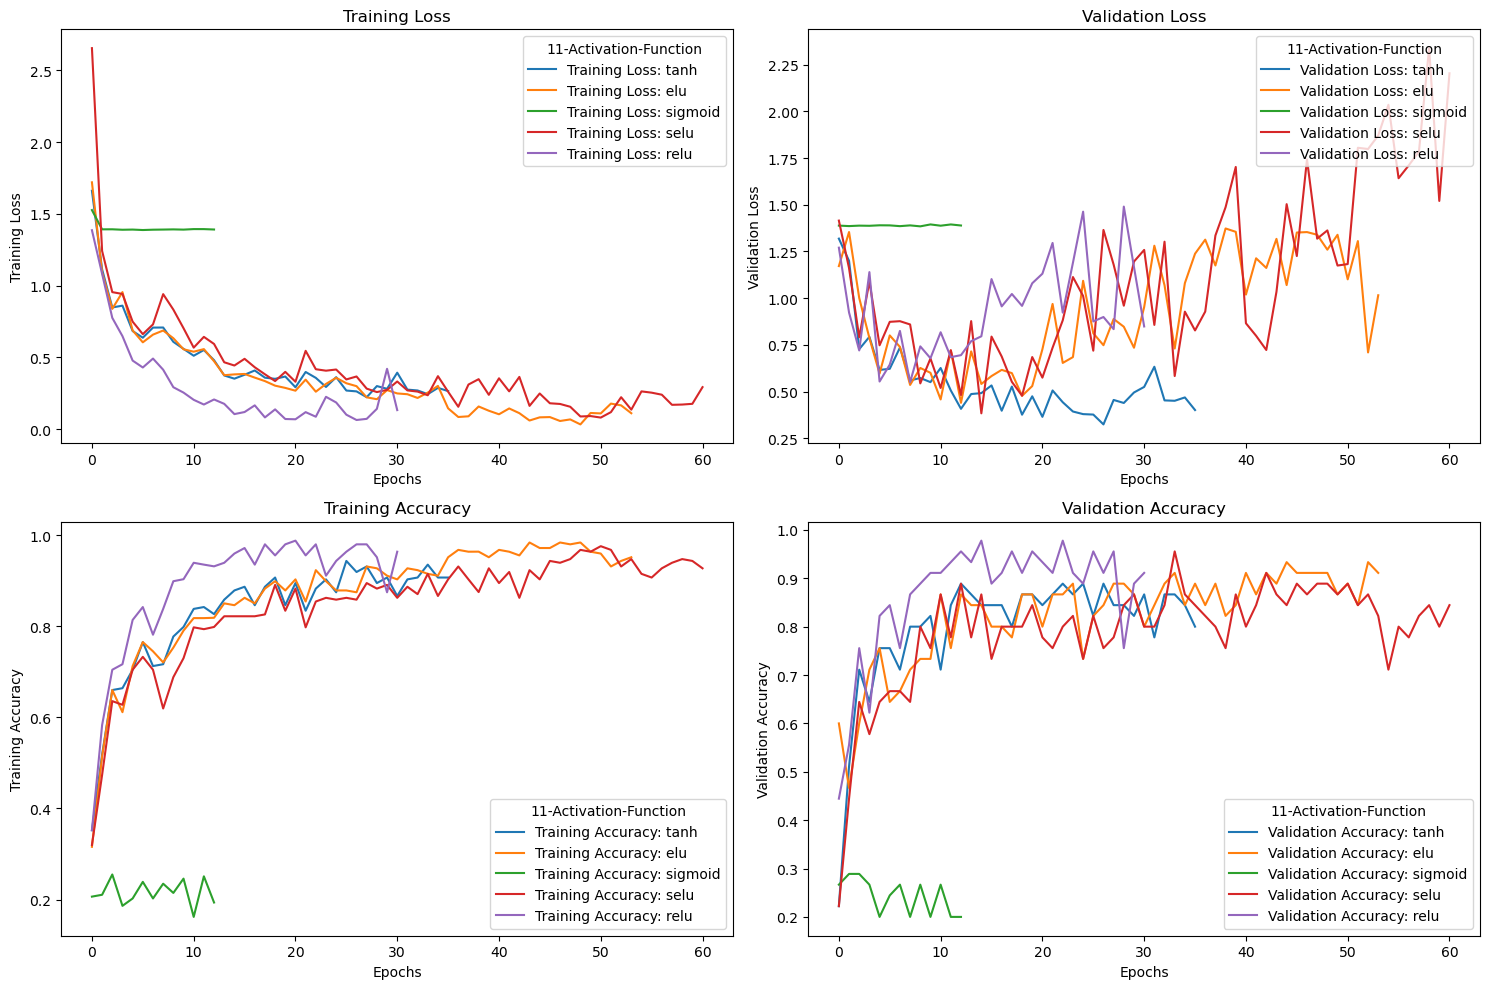

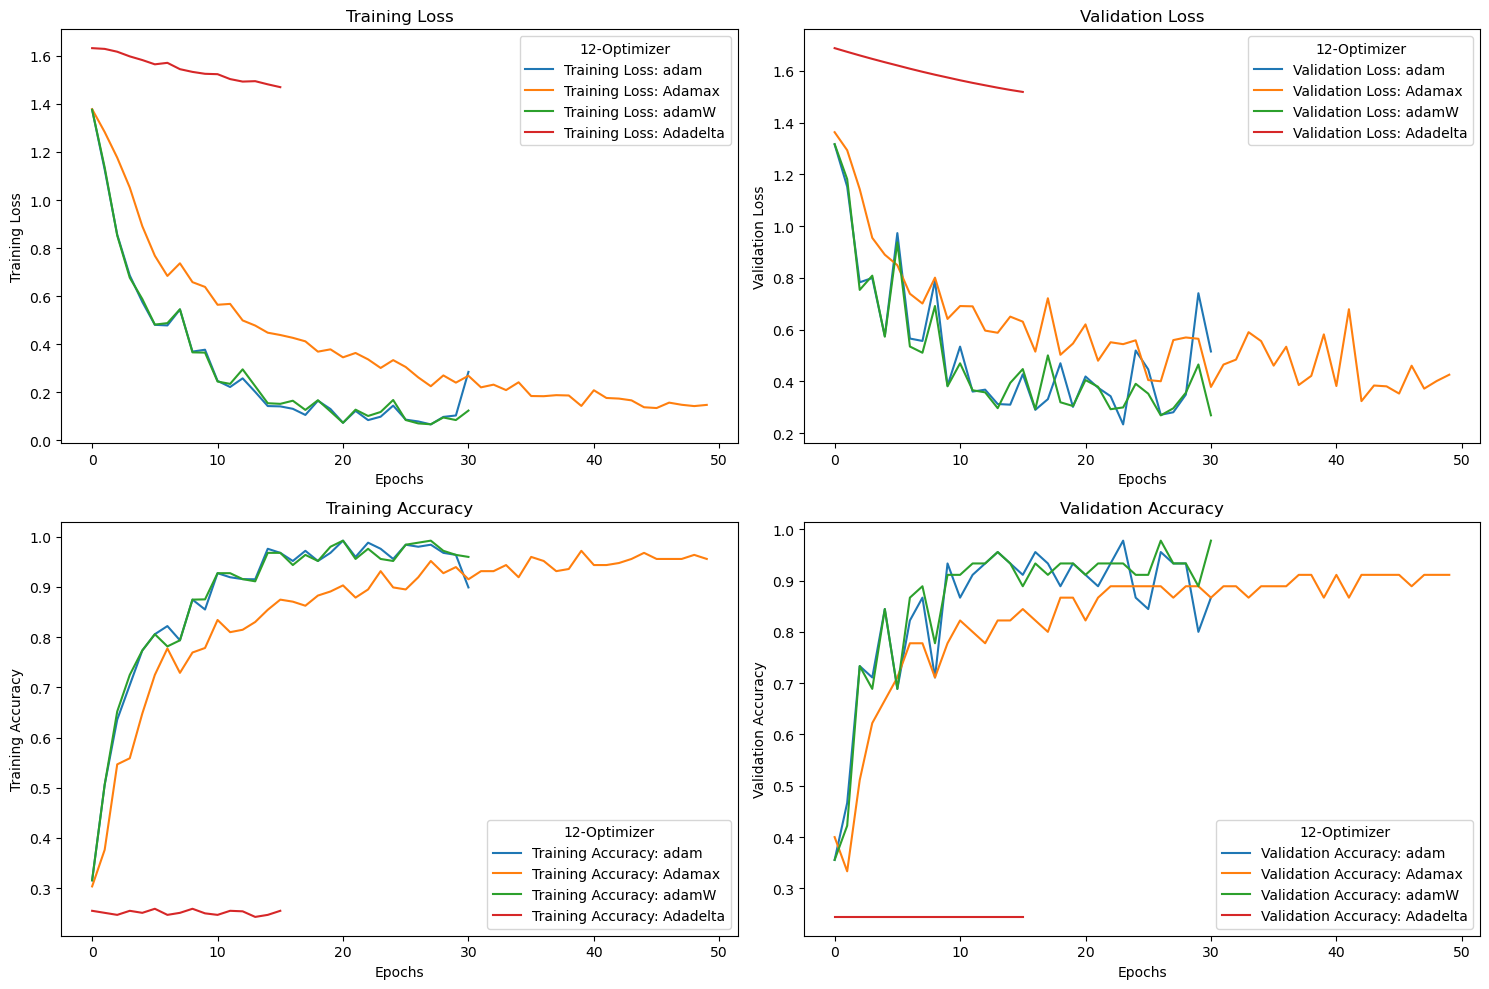

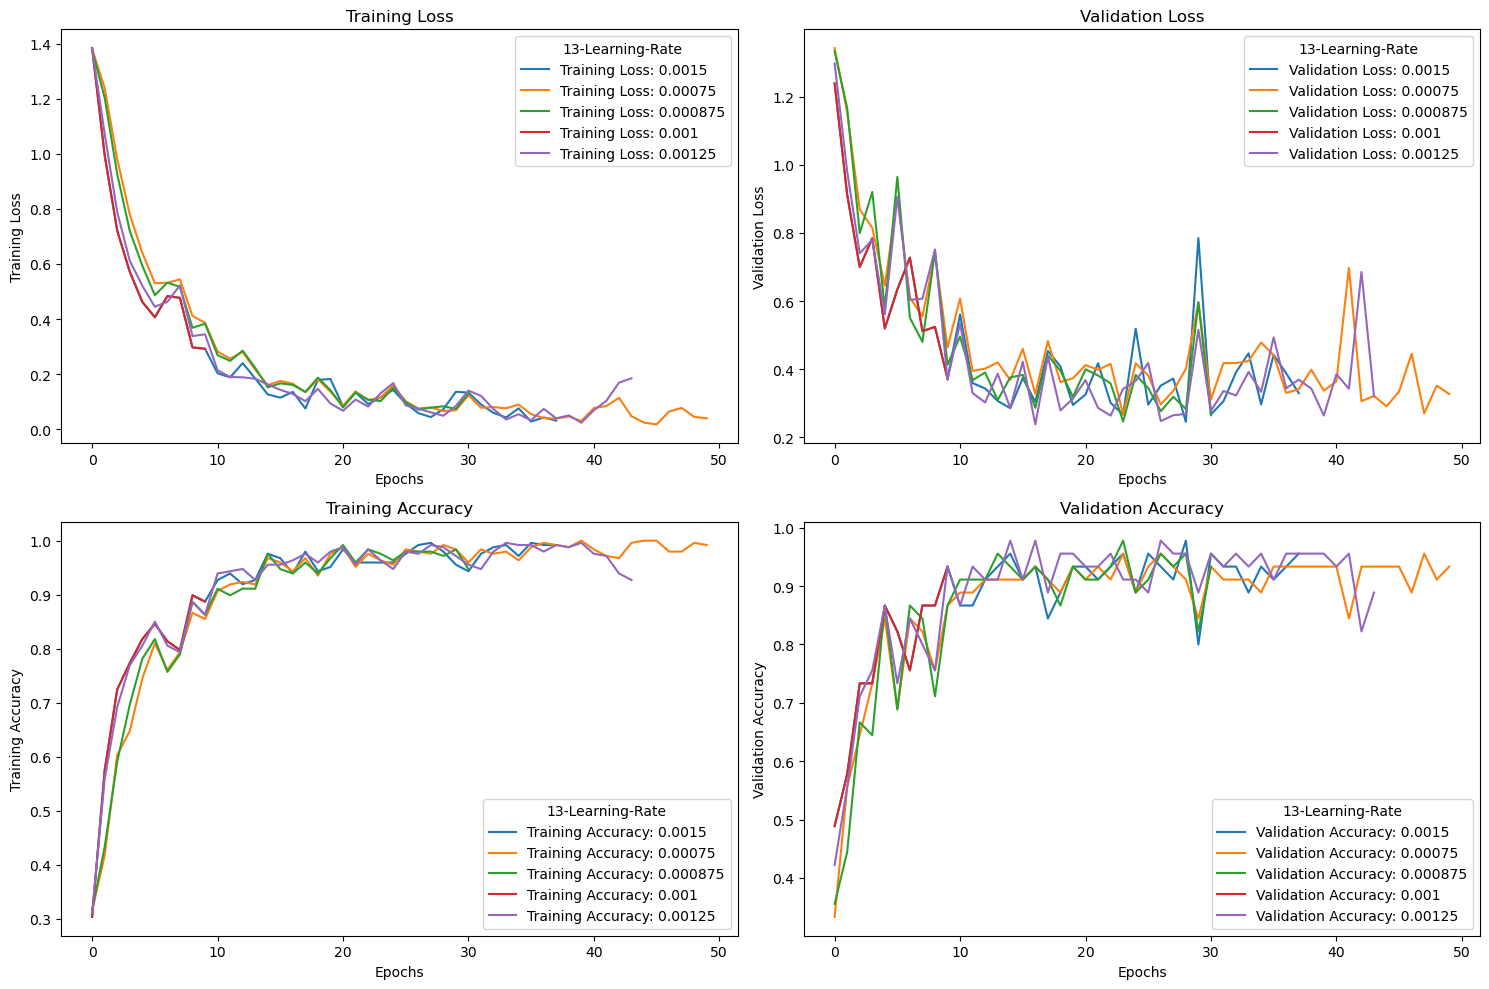

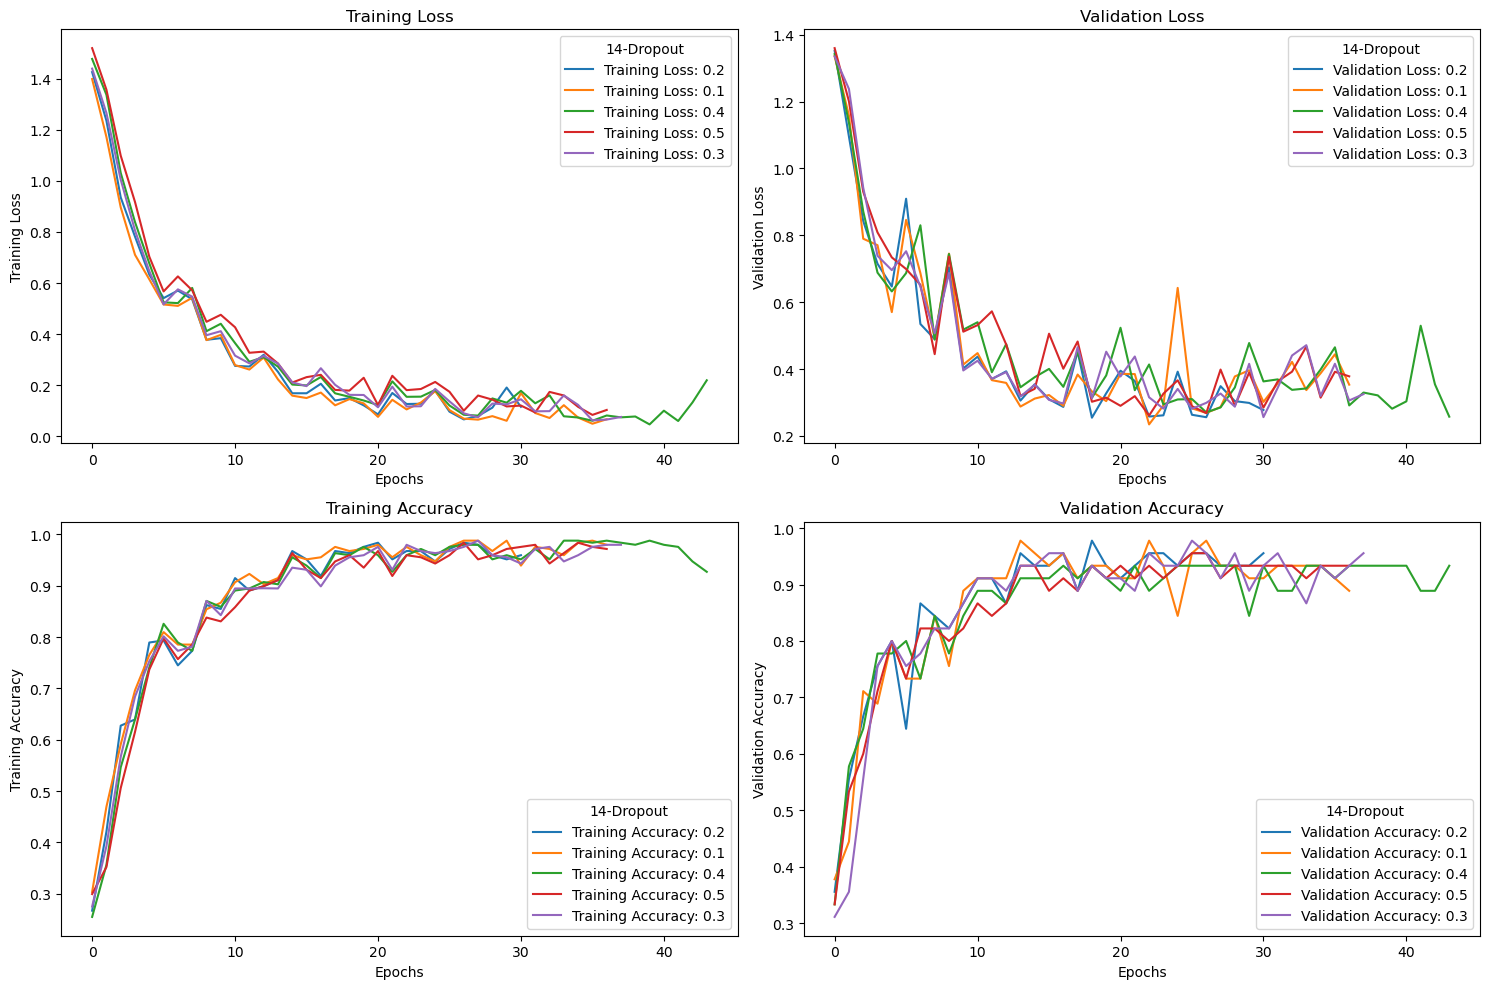

In [21]:
tuned_log_dir = os.path.join(os.getcwd(),"logger","hp_tuning")
plot_training_logger(tuned_log_dir)

Similar to part 3,the significant features that contributes to an improvement in the model accuracy will be futher investigated. Using those values, various combinations of these features will be explored and the final model architecture and hyperparameters are shown below.

In [22]:
def create_tuned_model(x_input_shape, output_layer):
    """
    creates a cnn model
    Parameters:
    x_input_shape (tuple): the shape of the input data
    output_layer (int): the number of neurons in the output layer
    Returns:
    keras model object.
    """
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, 
         kernel_size=(2, 2), activation="relu", input_shape=(x_input_shape), kernel_initializer=initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid"))
    model.add(tf.keras.layers.Conv2D(filters=32, 
         kernel_size=(2, 2), activation="relu", input_shape=(x_input_shape), kernel_initializer=initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid"))
    model.add(tf.keras.layers.Conv2D(filters=32, 
         kernel_size=(2, 2), activation="relu", input_shape=(x_input_shape), kernel_initializer=initializer))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid"))
    
    model.add(tf.keras.layers.Flatten())
    
    # hidden layers
    model.add(tf.keras.layers.Dense(units=64, activation="sigmoid", kernel_initializer=initializer))
    model.add(tf.keras.layers.Dropout(rate=0.3, seed=42))

    model.add(tf.keras.layers.Dense(units=output_layer, activation="softmax", kernel_initializer=initializer))    
    model.compile(loss="categorical_crossentropy", optimizer="adam", 
                    metrics=["accuracy"])
    return model

In [23]:
# Create a csv logger callback
tuned_earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', restore_best_weights=True, patience=10)
aug_tuned_logger_name = f"logger/train_model/04-tuned_augmented_data_model-{current_time}.log"
aug_tuned_logger = tf.keras.callbacks.CSVLogger(aug_tuned_logger_name, separator=",", append=False)

# Create a list of the loggers to fit in the model
tuned_aug_callbacks = [tuned_earlyStopping, aug_tuned_logger]

# Show the number of samples
print(f"The number of data in x_train is {len(x_train)}, y_train is {len(y_train)}")
print(f"The number of data in x_validation is {len(x_val)}, y_validation is {len(y_val)}")
print(f"The number of data in x_test is {len(x_test)}, y_test is {len(y_test)}")

The number of data in x_train is 255, y_train is 255
The number of data in x_validation is 45, y_validation is 45
The number of data in x_test is 60, y_test is 60


In [24]:
# Use the tuned hyperparameters
tuned_epochs = 100
tuned_batch_size = 8
tuned_num_of_samples = len(x_train)

# generate steps per epoch
tuned_steps_per_epoch = tuned_num_of_samples // tuned_batch_size

# augment the data
tuned_train_augment_generator, tuned_val_augment_generator = augment_data(x_train, y_train, 
                                                                          x_val, y_val, tuned_batch_size)

# create the model
aug_tuned_data_model = create_tuned_model(x_input_shape, output_layer)
aug_tuned_data_history = train_aug_gen_model(aug_tuned_data_model, tuned_train_augment_generator
                                       , tuned_batch_size, tuned_epochs, tuned_aug_callbacks
                                       , tuned_val_augment_generator, tuned_steps_per_epoch)

Epoch 1/100
31/31 [==============================] - 1s 32ms/step - loss: 1.4382 - accuracy: 0.2834 - val_loss: 1.3382 - val_accuracy: 0.4444
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 1.1766 - accuracy: 0.4494 - val_loss: 1.0289 - val_accuracy: 0.6667
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 0.9314 - accuracy: 0.6113 - val_loss: 0.7535 - val_accuracy: 0.7111
Epoch 4/100
31/31 [==============================] - 1s 31ms/step - loss: 0.7423 - accuracy: 0.6842 - val_loss: 0.6187 - val_accuracy: 0.8000
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 0.6275 - accuracy: 0.7379 - val_loss: 0.6247 - val_accuracy: 0.8222
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 0.4637 - accuracy: 0.8421 - val_loss: 0.4981 - val_accuracy: 0.8000
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 0.4193 - accuracy: 0.8704 - val_loss: 0.6067 - val_accuracy: 0.8667
Epoch 

The accuracy of the tuned augmented data model on the test dataset is: 
2/2 [==============================] - 0s 37ms/step - loss: 0.4152 - accuracy: 0.9167
[0.41515031456947327, 0.9166666865348816] 



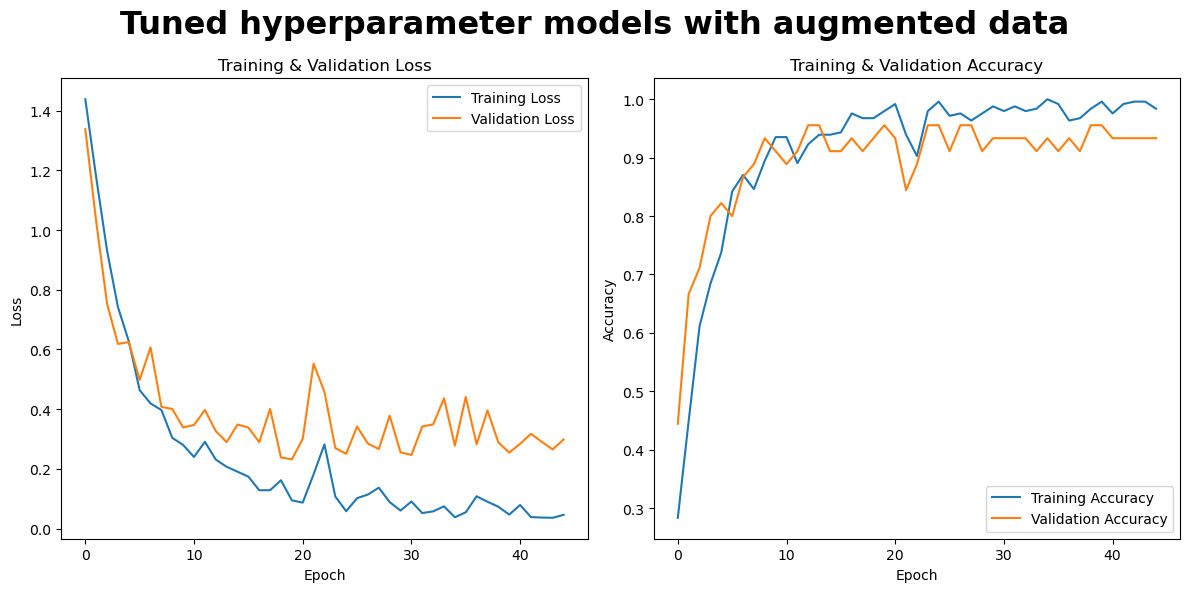

In [25]:
# test the model
print("The accuracy of the tuned augmented data model on the test dataset is: ")
tuned_model = test_model(aug_tuned_data_model, x_test, y_test)
print(tuned_model, "\n")

show_logger_plot(aug_tuned_logger_name, "Tuned hyperparameter models with augmented data")

From the results above, it can be seen the the final model architecture and hyperparameters yields the best results. The training accuracy closely alignes with validation accuracy which indicates that our model is generalising well to new data and that is exhibits less overfit in comparison to the rest of the models. In addition, the test accuracy is surpasses all of the other models in the previous sections. This shows that the process data processing, data augmentation and hyperparameters all contribute to help improve the the accuracy in the model. 

## Conclusion

From the results obtained, some possible avenues for improving the model performance can be done:
1) Introducing a larger dataset: The current dataset is small with 240 samples which is relatively small. Incorporating a larger more dataset can help to improve the model results by providing more examples for training
2) Using transfer learning: Using pre-trained model available can help to improve the model accuracy as we are able to transfer over learned features from the pre-trained models which can help cut down training time and also possibly lead to better performance
3) Exploring other model architectures: Other more advanced CNN architectures such as ResNet can be further explored which may help to improve the model performance.